---
title: "2023_Kronensicherung_Plesse_Kraefte_Schwingungen"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Kraefte_Schwingungen

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment) und installiere die Pakete linescale3 (LS3) und treeqinetic (PTQ) inklusive kj_core und kj_logger und weiteren requirements.

## Package Importe

Es werden zuerst benötigte Standard-Pakete importiert. Nachfolgend die zwei extra geschriebenen Pakete LS3 und PTQ. Fehler beim Import dieser zwei Pakete sind ggf. Bugs. Beide Pakete nutzen eine gemeinsame CodeBasis in den Paketen kj_core (Core-Package) und kj_logger (individualisiertes Logging des Verarbeitungs-Prozesses). Diese sollte i. d. R. über die requirements mit installiert werden.

### Import von Standardbibliotheken

Die folgenden Bibliotheken werden importiert, um grundlegende Funktionen für Strukturierung, Datenverarbeitung, Plotting und statistische Auswertung bereit zu stellen.

In [1]:
# Struktur
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc


### Import LineScale3

Das Paket linescale3 wurde vom Autor (Kyell Jensen) zum einfachen Analysieren, Plotten und zur Interpretation der CSV-Messdaten der lineScale3 Kraftmessdose der Firma lineGrip geschrieben (https://www.linegrip.com/linescale-3/). Das Packet ist auf GitHub verfügbar (https://github.com/kyellsen/linescale3). Nachfolgend wird das Packet und einige dort definierten Klassen importiert.

In [2]:
import linescale3 as ls3

# Test
ls3.help()


    Provides detailed guidance on setting up and using the linescale3 package.

    Setup:
        The setup function initializes the linescale3 package with user-defined settings.
        It configures logging, plotting, and the operational environment for data analysis.

        Example Usage:
            config, log_manager, plot_manager = setup('/path/to/directory', 'debug', safe_logs_to_file=True)

    Main Components:
        Series:
            Represents a sequence of measurements.

        Sensor:
            Defines a sensor used in experiments, containing metadata.

        Measurement:
            Represents a single measurement event with associated data and metadata.

    Further Information:
        For detailed API documentation, usage examples, and more, refer to the package documentation or visit the GitHub repository.
    


## Import TreeQinetic

Das Packet TreeQinetic wurde vom Autor (Kyell Jensen) zum einfachen Analysieren, Plotten und zur Interpretation der TXT-Messdaten der Picus TreeQinetic Elastometer und Inclinometer der Firma IML Instrumenta Mechanik Labor Electronic GmbH geschrieben (https://www.iml-electronic.de/produkt/picus-treeqinetic/). Nachfolgend wird das Packet und einige dort definierten Klassen importiert.

In [3]:
import treeqinetic as ptq

# Test
ptq.help()


    Provides detailed guidance on setting up and using the treeqinetic package.

    Setup:
        The setup function initializes the treeqinetic package with user-defined settings.
        It configures logging, plotting, and the operational environment for data analysis.

        Example Usage:
            config, log_manager, plot_manager = setup('/path/to/directory', 'debug', safe_logs_to_file=True)

    Main Components:
        Series:
            Represents a sequence of measurements.

        Sensor:
            Defines a sensor used in experiments, containing metadata.

        Measurement:
            Represents a single measurement event with associated data and metadata.

        Oscillation:
            Represents oscillation data, capturing the dynamic movements in the experiments. Selected from Measurement instance.

    Further Information:
        For detailed API documentation, usage examples, and more, refer to the package documentation or visit the GitHub repositor

## Daten Import und explorative Datenanalyse

Lege Pfade für Daten-Importe, Daten-Exporte etc. fest (ggf. anpassen an eigene Verzeichnisstruktur)

In [4]:
# Main
main_path = Path(r"C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse")
analyse_name = r"2023_Kronensicherung_Plesse_Kraefte_Schwingungen"
data_path = Path(r"C:\kyellsen\005_Projekte\2023_Kronensicherung_Plesse\020_Daten")  # Für alle Daten-Importe des Projektes gemeinsam
working_directory = main_path / "030_Analysen" / analyse_name / "working_directory"  # Für alle Daten-Exporte des Projektes gemeinsam


### METADATA: Lade Metadaten zum Versuch (Baumdaten, Geräteanordnung, Versuchsablauf)

Die Daten wurden während des Versuchs als GoogleSheet erfasst und abschließend als CSV-Dateien exportiert, um ein einfaches Einlesen zur ermöglichen.
Nachfolgend werden Datentypen für alle Spalten explizit angegeben, da es teils durch Python-Pandas zu Fehlerkennungen kommt.
Zusätzlich werden teils Spaltennamen vereinheitlicht und auf Englisch benannt.

#### Daten des Versuchsbaums (tree_df)

Die Tabelle `tree_df` liefert spezifische Informationen über den Versuchsbaum. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table').

In [5]:
dtype_dict = {
    'Attribut': 'string',
    'Wert': 'string',
    'Einheit': 'string'
}
tree_file = data_path / 'tree.csv'
tree_df = pd.read_csv(tree_file,
                      sep=';', decimal=',', na_values='NA',
                      dtype=dtype_dict)
tree_df

,Attribut,Wert,Einheit
0,Art,Fagus silvatica,name
1,HoeheStA,2615,cm
2,HoeheStB,2720,cm
3,Umfang1m,140,cm
4,KS_Laenge,135,cm
5,KS_Hoehe,1740,cm
6,KS_Umfang_StA,58,cm
7,KS_Umfang_StB,48,cm
8,Hoehe_Zwiesel,1031,cm


In [6]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
tree_df_latex = tree_df.copy()
latex_string = tree_df_latex.to_latex(index=False, escape=True, column_format="lrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsbaum}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Versuchsbaum}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsbaum}
    \begin{tabular}{lrr}
\toprule
Attribut & Wert & Einheit \\
\midrule
Art & Fagus silvatica & name \\
HoeheStA & 2615 & cm \\
HoeheStB & 2720 & cm \\
Umfang1m & 140 & cm \\
KS\_Laenge & 135 & cm \\
KS\_Hoehe & 1740 & cm \\
KS\_Umfang\_StA & 58 & cm \\
KS\_Umfang\_StB & 48 & cm \\
Hoehe\_Zwiesel & 1031 & cm \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Versuchsbaum}
\end{table}


#### Daten der Geräteanordnung am Baum (sensor_df)

Die Tabelle `sensor_df` enthält detaillierte Informationen zur Anordnung der Sensoren an den Bäumen im Rahmen des Experiments. Jede Zeile beschreibt die Platzierung eines Sensors. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table_dict').

In [7]:
sensor_position_file = data_path / 'sensor_position.csv'
dtype_dict = {
    'position_id': 'Int64',
    'type': 'category',
    'sensor_id': 'category',
    'location': 'category',
    'height': 'Int64',
    'circumference': 'Int64',
    'direction': 'category',
    'note': 'string'
}
# Original DataFrame
sensor_df = pd.read_csv(sensor_position_file, sep=';', decimal=',', na_values='NA', dtype=dtype_dict)
sensor_df["height"] = sensor_df["height"] / 100
sensor_df["circumference"] = sensor_df["circumference"]  / 100
sensor_df["diameter"] = sensor_df["circumference"] / np.pi
sensor_df.head()

,position_id,type,sensor_id,location,height,circumference,direction,note,diameter
0,1,LS3,14:BF:E6,rope,18.3,<NA>,NaN,<NA>,<NA>
1,2,LS3,14:99:1E,cable,17.4,<NA>,NaN,<NA>,<NA>
2,3,TMS1,015,StA,18.0,0.45,west,<NA>,0.143239
3,4,TMS1,014,StB,18.0,0.4,west,<NA>,0.127324
4,5,TMS1,013,StA,15.0,0.67,west,<NA>,0.213268


In [8]:
#sensor_df.dtypes

In [9]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
sensor_df_latex = sensor_df.copy()[["type", "sensor_id", "location", "direction", "height", "circumference", "diameter"]]
latex_string = sensor_df_latex.to_latex(index=False, escape=True, column_format="lllrrrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Geräteanordnung}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Geräteanordnung}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Geräteanordnung}
    \begin{tabular}{lllrrrr}
\toprule
type & sensor\_id & location & direction & height & circumference & diameter \\
\midrule
LS3 & 14:BF:E6 & rope & NaN & 18.30 & NaN & NaN \\
LS3 & 14:99:1E & cable & NaN & 17.40 & NaN & NaN \\
TMS1 & 015 & StA & west & 18.00 & 0.45 & 0.14 \\
TMS1 & 014 & StB & west & 18.00 & 0.40 & 0.13 \\
TMS1 & 013 & StA & west & 15.00 & 0.67 & 0.21 \\
TMS1 & 012 & StB & west & 15.00 & 0.56 & 0.18 \\
TMS1 & 011 & StA & west & 12.00 & 0.77 & 0.25 \\
TMS1 & 010 & StB & west & 12.00 & 0.76 & 0.24 \\
TMS1 & 007 & StAB & west & 9.00 & 1.14 & 0.36 \\
Elasto & 98 & StA & elongation & 16.85 & 0.64 & 0.20 \\
Elasto & 90 & StB & elongation & 16.55 & 0.58 & 0.18 \\
Elasto & 95 & StA & elongation & 11.60 & 0.77 & 0.25 \\
Elasto & 92 & StB & elongation & 11.60 & 0.76 & 0.24 \\
Inclino & 83 & StA & west & 11.60 & 0.77 & 0.25 \\
Inclino & 82 & StB & west & 11.60 & 0.76 & 0.24 \\
Inclino & 81 & Base & 

In [10]:
# Data Dictionary erstellen
data_dict = {
    "Variable": sensor_df_latex.columns.tolist(),
    "Deutsch": ["Typ", "Sensor ID", "Position", "Ausrichtung", "Höhe", "Umfang", "Durchmesser"],
    "Datentyp": [str(dtype) for dtype in sensor_df_latex.dtypes.tolist()],
    "Einheit": ["-", "-", "-", "-", "m", "m", "m"],
    "Beschreibung": ["Typ des Sensors", "ID des Sensors", "Ort am Baum", "Ausrichtung/Himmelsrichtung",
                     "Höhe ü. dem Boden", "Umfang des Stammes am Sensor", "Durchmesser berechnet"]
}

# Dataframe für das Data Dictionary erstellen
data_dict_df = pd.DataFrame(data_dict)
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Geräteanordnung Daten Dokumentation}}
    {latex_string_dict}
    \\label{{tab:Feldversuch_2_Geräteanordnung_Daten_Dokumentation}}
\\end{{table}}
"""
print(latex_table_dict)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Geräteanordnung Daten Dokumentation}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
type & Typ & category & - & Typ des Sensors \\
sensor\_id & Sensor ID & category & - & ID des Sensors \\
location & Position & category & - & Ort am Baum \\
direction & Ausrichtung & category & - & Ausrichtung/Himmelsrichtung \\
height & Höhe & Float64 & m & Höhe ü. dem Boden \\
circumference & Umfang & Float64 & m & Umfang des Stammes am Sensor \\
diameter & Durchmesser & Float64 & m & Durchmesser berechnet \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Geräteanordnung_Daten_Dokumentation}
\end{table}


#### Daten des Versuchsablaufs (series_df)

Die Tabelle `series_df` enthält das Protokoll des Versuchsablaufes der einzelnen Messungen. Jede Zeile repräsentiert eine einzelne Messung. Die Variablenbeschreibung ist aus der Latex Tabelle zu entnehmen (siehe unten: 'latex_table_dict').

##### Behandlungsvariante/Kronensicherung Kategorien

- **`free`**: Der Baum konnte frei ohne Kronensicherung nach dem Release ausschwingen.
  
- **`gefa_dynamic`**: In ca. 2/3 der Baumhöhe wurde ein dynamisches Gefa Gurtband 4t dynamisch nach ZTV-Baumpflege mit leichtem Durchhang installiert. Das Ausschwingen wurde durch die KS abgedämpft. Da die Sicherung ohne Vorspannung installiert wurde, zeigen die Plots (/ls3/plots/force_vs_time_1/) von '14:99:1E' sowohl am Anfang als auch am Ende ca. 0 kN Kraft an (LogNr 1 bis 9).

- **`cobra_static`**: In ca. 2/3 der Baumhöhe wurde eine statische Cobra ultrastatic 7t (Dyneema) Sicherung installiert. Die Vorspannung betrug ca. 0,4 kN, wie sich in den Plots (/ls3/plots/force_vs_time_1/) von '14:99:1E' gut erkennen lässt. Durch das Zusammenziehen der Stämmlinge ist die Kronensicherung vor dem Release vollständig lastfrei (0 kN). Nach dem Release pendelt sich die Kraft ca. bei 0,4 kN ein (LogNr 10-18).

- **`cobra_static_slack`**: Ähnlich der `cobra_static`, jedoch wurde die Vorspannung entfernt. Aufgrund von Regen wurde nur eine Messung durchgeführt und die Serie frühzeitig abgebrochen.


In [11]:
# Series
series_file = data_path / 'series.csv'

# Datentypen für das Einlesen der Daten definieren
series_dtype_dict = {
    'measurement_id': 'Int64',
    'time': 'string',
    'release_force_target': 'float64',
    'treatment': 'category',
    '14:BF:E6': 'Int64',
    '14:99:1E': 'Int64'
}

# CSV-Datei einlesen, Datentypen anwenden, Spalten umbenennen und Datumsformat umwandeln
series_df = pd.read_csv(series_file, sep=';', decimal=',', na_values='NA', dtype=series_dtype_dict)
series_df['time'] = pd.to_datetime(series_df['time'], format="%H:%M:%S").dt.time

from pandas.api.types import CategoricalDtype

# Konvertieren von 'treatment' in eine kategorische Variable mit definierter Reihenfolge
treatment_order = ['free', 'gefa_dynamic', 'cobra_static']
treatment_category = CategoricalDtype(categories=treatment_order, ordered=True)
series_df['treatment'] = series_df['treatment'].astype(treatment_category)

# Ergebnis
series_df.head(3)

,id,time,release_force_target,treatment,14:BF:E6,14:99:1E
0,1,10:10:00,2.5,free,1,<NA>
1,2,10:20:00,2.8,free,2,<NA>
2,3,10:28:00,2.8,free,3,<NA>


In [12]:
#series_df.dtypes

In [13]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
series_df_latex = series_df
latex_string = series_df_latex.to_latex(index=False, escape=True, column_format="rrrlrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsablauf}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Versuchsablauf}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsablauf}
    \begin{tabular}{rrrlrr}
\toprule
id & time & release\_force\_target & treatment & 14:BF:E6 & 14:99:1E \\
\midrule
1 & 10:10:00 & 2.50 & free & 1 & NaN \\
2 & 10:20:00 & 2.80 & free & 2 & NaN \\
3 & 10:28:00 & 2.80 & free & 3 & NaN \\
4 & 10:47:00 & 2.80 & free & 4 & NaN \\
5 & 10:53:00 & 2.40 & free & 5 & NaN \\
6 & 11:00:00 & 2.40 & free & 6 & NaN \\
7 & 11:05:00 & 2.40 & free & 7 & NaN \\
8 & 11:10:00 & 2.00 & free & 8 & NaN \\
9 & 11:19:00 & 2.00 & free & 9 & NaN \\
10 & 10:22:00 & 2.00 & free & 10 & NaN \\
11 & 13:30:00 & 2.80 & gefa\_dynamic & 11 & 1 \\
12 & 13:40:00 & 2.80 & gefa\_dynamic & 12 & 2 \\
13 & 13:46:00 & 2.80 & gefa\_dynamic & 13 & 3 \\
14 & 13:57:00 & 2.40 & gefa\_dynamic & 15 & 4 \\
15 & 14:02:00 & 2.40 & gefa\_dynamic & 16 & 5 \\
16 & 14:06:00 & 2.40 & gefa\_dynamic & 17 & 6 \\
17 & 14:10:00 & 2.00 & gefa\_dynamic & 18 & 7 \\
18 & 14:15:00 & 2.00 & gefa\_dynamic & 19 & 8 \\
19 & 14:19

In [14]:
# Data Dictionary erstellen
data_dict = {
    "Variable": series_df_latex.columns.tolist(),
    "Deutsch": ["ID", "Zeit", "Vorspannung", "Behandlungsvar.", "LS3_Zugseil", "LS3_KS"],
    "Datentyp": [str(dtype) for dtype in series_df_latex.dtypes.tolist()],
    "Einheit": ["-", "Zeit", "kN", "-", "-", "-"],
    "Beschreibung": ["ID der Messung", "ca. Uhrzeit Beginn", "F vor Release Zugseil (Soll)", "Behandlung Keine/KS-Typ",
                     "LogNr. LS3 im Zugseil", "LogNr. LS3 in KS"]
}

data_dict_df = pd.DataFrame(data_dict)
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Versuchsablauf Daten Dokumentation}}
    {latex_string_dict}
    \\label{{tab:Feldversuch_2_Versuchsablauf_Daten_Dokumentation}}
\\end{{table}}
"""
print(latex_table_dict)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Versuchsablauf Daten Dokumentation}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
id & ID & int64 & - & ID der Messung \\
time & Zeit & object & Zeit & ca. Uhrzeit Beginn \\
release\_force\_target & Vorspannung & float64 & kN & F vor Release Zugseil (Soll) \\
treatment & Behandlungsvar. & category & - & Behandlung Keine/KS-Typ \\
14:BF:E6 & LS3\_Zugseil & Int64 & - & LogNr. LS3 im Zugseil \\
14:99:1E & LS3\_KS & Int64 & - & LogNr. LS3 in KS \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Versuchsablauf_Daten_Dokumentation}
\end{table}


## LS3: Daten der Kraftmessdosen (Linescale3 Data = LS3)

### LS3: Daten Import

Die Funktion 'ls3.setup' erstellt Instanzen spezifischer Klassen, die für das Paket notwendig sind (CONFIG, LOG_MANAGER, PLOT_MANAGER). 

Über die Klasse 'ls3.Series' wird eine neue Messreihe initialisiert und als 'ls3_series' gespeichert. Im Verzeichnis 'ls3_data_path' finden sich die Messdaten von zwei lineScale3 ('LS14BFE6' und 'LS14991E').
LS14BFE6: Befand sich während der Messung im Zugseil zwischen den Stämmlingen und erfasste die Vorspannung. Es wurden insgesamt 31 Logs (hier Measurements) aufgezeichnet. Eine Messfrequenz von 40 Hz erschien hier ausreichend.
LS14991E: Befand sich während der Messung in der Kronensicherung und hat die Kraft in der Kronensicherung nach dem Release gemessen. Es wurden 19 Logs erfasst, da die ersten Messungen als Referenz ohne Kronensicherung stattfanden. Hier wurde die maximale Messfrequenz von 1028 Hz gewählt, um Lastspitzen optimal zu erfassen.

In [15]:
ls3.setup(working_directory=working_directory, log_level="info", safe_logs_to_file=True)

ls3_data_path = data_path / 'LS3'
ls3_series = ls3.classes.Series(name=analyse_name, path=ls3_data_path)

2024-12-14 10:35:04 [INFO] kj_logger.update_config: <kj_logger.LogManager object at 0x0000015E9EA3A590> initialized - update_config! Code: 000
2024-12-14 10:35:04 [INFO] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ls3 was successfully created.
2024-12-14 10:35:04 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ls3!
2024-12-14 10:35:04 [INFO] kj_core.core_config.__init__: <linescale3.config.Config object at 0x0000015E9E7485D0> initialized! Code: 001
2024-12-14 10:35:04 [INFO] linescale3.setup: ls3: Setup linescale3 package!
2024-12-14 10:35:04 [INFO] kj_core.utils.plot_manager.__init__: <kj_core.utils.plot_manager.PlotManager object at 0x0000015EA09BFE10> initialized! Co

### LS3: Explorative Datenanalyse

Da teilweise für jede Messung und jeden Sensor ein Plot generiert wird, werden diese nicht im Notebook direkt angezeigt, sondern im Explorer gespeichert. Die Plots liegen entsprechend im working_directory in den Verzeichnissen ls3/plots/ bzw. ptq/plots.

'ls3_series.plot_force_vs_time' erstellt für jede Messung für beide eingesetzten LineScales einen Plot, in dem die ermittelte Kraft (force in kN) gegenüber der Zeit (sec_since_start) abgebildet wird. Die Plots werden im Verzeichnis 'ls3/plots/force_vs_time_1/' abgelegt.

14:BF:E6: Hat die tatsächliche Vorspannung ermittelt und hat entsprechend für alle 29 (-2) Messungen (experiment_id) einen Log aufgezeichnet.
Aufgrund der Messtechnik wurden 2 Logs erstellt, die keine Messung darstellen. Diese dürfen nicht mit ausgewertet werden (Measurement ID 14 und 30).

14:99:1E: Hat die Lasten in der Kronensicherung aufgezeichnet und hat entsprechend nur für die 19 (-1) Messungen mit Kronensicherungen einen Log aufgezeichent.

In [16]:
#ls3_series.plot_force_vs_time() # Basis Funktion ohne ergänzende Markierungen für max and release (-force)
ls3_series.plot_force_vs_time_with_max_and_release()

2024-12-14 10:35:06 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '1', name: '14991E_23_03_22_14_41_10', sensor_id: '14:99:1E')'.
2024-12-14 10:35:06 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '2', name: '14991E_23_03_22_14_47_59', sensor_id: '14:99:1E')'.
2024-12-14 10:35:06 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '3', name: '14991E_23_03_22_14_55_03', sensor_id: '14:99:1E')'.
2024-12-14 10:35:06 [INFO] linescale3.classes.measurement.plot_force_vs_time_with_max_and_release: plot_force_vs_time_with_max_and_release for measurement: 'Measurement(id: '4', name: '14991E_23_03_22_15_04_05', sensor_id: '14:99:1E')'.
2024-12-14 10:35:07 [INFO] linescale3.classes.measur

#### LS3: Metadata DataFrame

'ls3_series.metadata_df' enthält für jeden Log (measurement_id) der 2 LineScales die Metadaten der Messung.

Parameter / Einstellung LineScale für Messung:
- `datetime`: Startzeitpunkt der Messung
- `measurement_id`: LogNr
- `unit`: Einheit für Kraft
- `mode`: ABS für absolute Kraft
- `rel_zero`: Für ABS-Modus nicht relevant
- `speed`: Messgeschwindigkeit in Hz
- `trig`: Mindestkraft für Messbeginn in kN
- `stop`: Stop Messung bei Kraft-Unterschreitung (hier feste Zeitspanne für Messung)
- `pre`: Zeitraum, der vor dem trigger-zeitpunkt nachträglich ergänzt wird (in Sekunden)
- `catch`: Zu erfassender Zeitraum (in Sekunden)
- `total`: Gesamter Messzeitraum

Korrekturfaktor:
- `timing_correction_factor`: Die Auswertung zeigt, dass im LineScale die Zeit ca. mit dem Faktor 0.9 falsch erfasst wird. Die tatsächliche Abtastrate, Duration etc. wird entsprechend korrigiert.

Berechnete Parameter:
- `datetime_start`: Startzeitpunkt der Messung
- `datetime_end`: Endzeitpunkt der Messung
- `duration`: Dauer der Messung
- `length`: Anzahl der erfassten Messpunkte
- `max`: Index und Wert der maximalen Kraft in kN
- `mean`: arithmetisches Mittel der Kraft
- `median`: median der Kraft
- `min`: Index und Wert der minmalen Kraft in kN
- `release`: Für jeden Log von 14:BF:E6 (LineScale zur Messung der Vorspannung) wurde die Kraft in kN ermittelt, die kurz vor dem Release vorlag. Diese Kraft ist in den Plots (/ls3/plots/force_vs_time_1/) als grüne Linie markiert. Die entsprechende Funktion befindet sich in 'ls3/classes/measurement.py' und heißt 'get_release_force'.

Anmerkung zu get_release_force: Die Funktion filtert alle Kraftwerte über 1.0 kN (Parameter min_force=1.0). Innerhalb der gefilterten Werte wird ein Bereich ausgewählt, der 3 Sekunden vor dem Ende der Messung endet (Parameter distance_to_end_sec=3) und insgesamt 5 Sekunden lang ist (Parameter window_sec=5). Für diesen Zeitraum wird der Mittelwert (Mean) berechnet. Die release_force ist somit der Mittelwert eines 5-sekündigen Plateaus vor dem Release und wird nicht durch kurzzeitige Lastspitzen im Zugseil verfälscht.

In [17]:
ls3_metadata_df = ls3_series.metadata_df
ls3_metadata_df.head(3)

,measurement_name,sensor_id,datetime,measurement_id,unit,mode,rel_zero,speed,trig,stop,...,timing_correction_factor,datetime_start,datetime_end,duration,length,max,mean,median,min,release
0,14991E_23_03_22_14_41_10,14:99:1E,2022-03-23 14:41:10,1,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:41:10,2022-03-23 14:41:26.199296875,16.199296,23040,"(4737, 1.48)",0.111598,0.06,"(36, 0.0)",NaN
1,14991E_23_03_22_14_47_59,14:99:1E,2022-03-23 14:47:59,2,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:47:59,2022-03-23 14:48:15.199296875,16.199296,23040,"(4721, 1.44)",0.117817,0.06,"(135, 0.0)",NaN
2,14991E_23_03_22_14_55_03,14:99:1E,2022-03-23 14:55:03,3,kN,ABS,n/a,1280,0.8,0.0,...,0.9,2022-03-23 14:55:03,2022-03-23 14:55:19.199296875,16.199296,23040,"(3867, 1.33)",0.104375,0.06,"(81, 0.0)",NaN


### LS3: Daten Vorbereitung (Data Cleaning)
Definition relevanter Spalten aus ls3_metadata_df und Anpassung der Datenstruktur, um nur die erforderlichen Variablen abzufragen. 

In [18]:
# Selecting relevant columns and creating a copy to avoid SettingWithCopyWarning
select_cols = ['sensor_id', 'measurement_id', 'max', 'release']
ls3_metadata_df = ls3_metadata_df[select_cols].copy()

# Extracting values from tuples in 'max'
ls3_metadata_df['max'] = ls3_metadata_df['max'].apply(lambda x: x[1] if isinstance(x, tuple) else x)
ls3_metadata_df.head(3)

,sensor_id,measurement_id,max,release
0,14:99:1E,1,1.48,NaN
1,14:99:1E,2,1.44,NaN
2,14:99:1E,3,1.33,NaN


## PTQ: Daten der Elastometer (PicusTreeQinetic Data = PTQ)

### PTQ: Daten Import

Aus dem Zugversuchsset wurden 4 Elastometer und 3 Inclinometer verwendet.

Die Elastometer waren auf dem rechten und linken Stämmling auf der Außenseite in zwei Ebenen platziert. Beim Zusammenziehen der Stämmlinge messen diese entsprechnd eine Faserdehnung, beim Ausschwingen der Stämmlinge über ihre Ruhelage hinaus nach außen eine Faserstauchung.

Die Inclinometer Daten werden hier ebefalls geladen, erschienen aber weniger geeignet zur Auswertung und werden entspricht nicht weiter berücksichtigt.

Die Funktion 'ptq.setup' erstellt div. Instanzen, die für das Paket notwendig sind (CONFIG, LOG_MANAGER, PLOT_MANAGER). 

Über die Klasse 'ptq.Series' wird eine neue Messreihe initialisiert und als 'ptq_series' gespeichert. Im Verzeichnis ptq_data_path finden sich die PTQ Daten als TXT von insgesamt 29 Messungen. Eine Datei enthält jeweils die Daten für alle Inclinometer und Elastometer.

In [19]:
ptq.setup(working_directory=working_directory, log_level="info", safe_logs_to_file=True)

ptq_data_path = data_path / 'PTQ/data_txt'
ptq_series = ptq.classes.Series(name=analyse_name, path=ptq_data_path)

elasto_names = ["Elasto(95)", "Elasto(98)", "Elasto(92)", "Elasto(90)"]

2024-12-14 10:35:18 [INFO] kj_logger.update_config: <kj_logger.LogManager object at 0x0000015E9EA3A590> initialized - update_config! Code: 000
2024-12-14 10:35:18 [INFO] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ptq was successfully created.
2024-12-14 10:35:18 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\ptq!
2024-12-14 10:35:18 [INFO] kj_core.core_config.__init__: <treeqinetic.config.Config object at 0x0000015EA0BC7010> initialized! Code: 001
2024-12-14 10:35:18 [INFO] treeqinetic.setup: ptq: Setup treeqinetic package!
2024-12-14 10:35:18 [INFO] kj_core.utils.plot_manager.__init__: <kj_core.utils.plot_manager.PlotManager object at 0x0000015EA09E30D0> initialized!

### PTQ: Explorative Datenanalyse

Übersicht über alle vom PTQ erfassten Daten über alle Messungen gemeinsam (Elastos und Inclinos).

In [20]:
ptq_df = ptq_series.get_measurements_df()
ptq_df.describe()

,ID,Nr,Datetime,Sec_Since_Start,Elasto(98),Elasto(95),Elasto(92),Elasto(90),Inclino(85)X,Inclino(85)Y,Inclino(83)X,Inclino(83)Y,Inclino(82)X,Inclino(82)Y,Inclino(81)X,Inclino(81)Y
count,17836.000000,17836.000000,17836,17836.000000,17461.000000,17468.000000,17657.000000,17676.000000,17448.000000,17448.0,17704.000000,17704.000000,17435.000000,17435.000000,17574.000000,17574.000000
mean,15.249047,338.457502,2023-03-22 13:34:17.235428864,85.133799,81.627536,105.786833,118.740437,191.147720,0.586046,0.0,0.735073,0.022071,-0.495272,-0.195005,0.009151,0.010782
min,1.000000,0.000000,2023-03-22 10:10:39.830198,0.000000,-192.900000,-119.100000,-111.000000,-217.800000,0.000000,0.0,-7.149000,-3.127000,-3.483000,-2.228000,-1.346000,-0.660000
25%,8.000000,153.000000,2023-03-22 11:11:37.444994048,38.984250,16.900000,8.400000,5.700000,13.475000,0.283000,0.0,0.424000,-0.102000,-0.922000,-0.397500,-0.006000,-0.005750
50%,16.000000,309.000000,2023-03-22 14:08:40.921139968,77.763500,95.100000,128.500000,139.500000,235.850000,0.557000,0.0,0.742000,0.000000,-0.522000,-0.221000,-0.002000,-0.001000
75%,23.000000,469.000000,2023-03-22 15:31:05.232380160,117.784500,137.500000,184.700000,213.100000,337.600000,0.848250,0.0,1.036000,0.127000,-0.070000,0.000000,0.001000,0.002000
max,29.000000,1392.000000,2023-03-22 16:12:55.455613,345.709000,234.600000,266.300000,291.500000,429.600000,7.029000,0.0,7.341000,4.525000,1.570000,1.147000,2.955000,0.526000
std,8.422199,242.404703,NaN,60.383660,64.555211,89.518611,101.978415,157.750503,0.392076,0.0,0.561636,0.253933,0.491294,0.271169,0.226831,0.075625


#### PTQ: Einhaltung der maximalen Faserdehnung/-Stauchung

In [21]:
ptq_df_elasto_summary = ptq_df[elasto_names].describe()
ptq_df_elasto_summary

,Elasto(95),Elasto(98),Elasto(92),Elasto(90)
count,17468.000000,17461.000000,17657.000000,17676.000000
mean,105.786833,81.627536,118.740437,191.147720
std,89.518611,64.555211,101.978415,157.750503
min,-119.100000,-192.900000,-111.000000,-217.800000
25%,8.400000,16.900000,5.700000,13.475000
50%,128.500000,95.100000,139.500000,235.850000
75%,184.700000,137.500000,213.100000,337.600000
max,266.300000,234.600000,291.500000,429.600000


Analyse maximaler Dehnung und Stauchung, Prüfung auf Einhaltung der Elastizitätsgrenze (Fagus s. ca. 520 µm über 200~mm Länge des Elastos). 
Elasto(90) mit 429.6 mit der maximalen Faserdehnung

In [22]:
ptq_df_elasto_min_max = ptq_df_elasto_summary.loc[['min', 'max']]
ptq_df_elasto_min_max

,Elasto(95),Elasto(98),Elasto(92),Elasto(90)
min,-119.1,-192.9,-111.0,-217.8
max,266.3,234.6,291.5,429.6


In [23]:
latex_string = ptq_df_elasto_min_max.to_latex(index=True, escape=True, column_format="lrrrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Maximale Dehnungswerte der Elastometer in µm, erfasst über alle Messungen}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Elasto_Max}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Maximale Dehnungswerte der Elastometer in µm, erfasst über alle Messungen}
    \begin{tabular}{lrrrr}
\toprule
 & Elasto(95) & Elasto(98) & Elasto(92) & Elasto(90) \\
\midrule
min & -119.10 & -192.90 & -111.00 & -217.80 \\
max & 266.30 & 234.60 & 291.50 & 429.60 \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Elasto_Max}
\end{table}


#### PTQ: Berechnung der maximalen Dehnungs- und Stauchungswerte 

Für jedes Elasto innerhalb jeder Messung getrennt. Werte werden bei der Gesamtauswertung später verwendet.

In [24]:
# Gruppiere nach ID und berechne min und max für jede Elasto-Spalte
ptq_df_elasto_min_max = ptq_df.groupby('ID')[elasto_names].agg(['min', 'max'])
ptq_df_elasto_min_max.head(3)

Elasto(95)        Elasto(98)        Elasto(92)        Elasto(90)       
          min    max        min    max        min    max        min    max
ID                                                                        
1      -119.1  215.0     -132.8  192.8      -86.6  240.9     -168.1  368.0
2       -90.4  254.4      -93.8  207.9     -111.0  282.6     -202.2  429.6
3      -106.8  262.2     -139.1  193.7      -87.0  291.5     -180.0  427.8

In [25]:
latex_string = ptq_df_elasto_min_max.reset_index().to_latex(index=False, escape=True, column_format="lrrrrrrrr", float_format="{:0.0f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Maximalwerte Elastometer vollständig, Stauchung-/Dehunung in µm über 200~mm Länge Messgerät}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Elasto_Max_vollständig}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Maximalwerte Elastometer vollständig, Stauchung-/Dehunung in µm über 200~mm Länge Messgerät}
    \begin{tabular}{lrrrrrrrr}
\toprule
ID & \multicolumn{2}{r}{Elasto(95)} & \multicolumn{2}{r}{Elasto(98)} & \multicolumn{2}{r}{Elasto(92)} & \multicolumn{2}{r}{Elasto(90)} \\
 & min & max & min & max & min & max & min & max \\
\midrule
1 & -119 & 215 & -133 & 193 & -87 & 241 & -168 & 368 \\
2 & -90 & 254 & -94 & 208 & -111 & 283 & -202 & 430 \\
3 & -107 & 262 & -139 & 194 & -87 & 292 & -180 & 428 \\
4 & -116 & 250 & -161 & 172 & -110 & 267 & -218 & 402 \\
5 & -71 & 237 & -114 & 196 & -94 & 252 & -187 & 386 \\
6 & -112 & 198 & -167 & 146 & -99 & 231 & -203 & 345 \\
7 & -111 & 240 & -158 & 192 & -101 & 229 & -207 & 344 \\
8 & -95 & 180 & -141 & 154 & -88 & 208 & -181 & 321 \\
9 & -102 & 202 & -134 & 165 & -89 & 203 & -181 & 315 \\
10 & -109 & 187 & -157 & 129 & -81 & 208 & -176 & 313 \\
11 & -64 & 221 & -158 & 159 & -51 & 244 & -210

Die maximalen Dehnungs- und Stauchungswerte der Elastometer werden in der Struktur angepasst, um später sie mit den weiteren Daten zusammenzuführen.

In [26]:
ptq_df_elasto = ptq_df_elasto_min_max.stack(level=0).reset_index()

ptq_df_elasto = ptq_df_elasto.rename(columns={
    'ID': 'id', 
    'level_1': 'sensor_name',
    'max': 'max_strain',
    'min': 'max_compression'
})

ptq_df_elasto.head(3)

C:\Users\mail\AppData\Local\Temp\ipykernel_4648\3739918856.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ptq_df_elasto = ptq_df_elasto_min_max.stack(level=0).reset_index()


,id,sensor_name,max_compression,max_strain
0,1,Elasto(90),-168.1,368.0
1,1,Elasto(92),-86.6,240.9
2,1,Elasto(95),-119.1,215.0


#### PTQ: Plotten aller Messungen bzw. Elastometer

Plotten der 4 verwendeten Elastometer in einem Plot für jede Messung. Die Plots werden im Verzeichnis ptq/plots/multi_sensors_vs_time_1/ abgelegt.
Für alle Messungen und Elastometer ist gut zu erkennen, wie die Faserdehnung während des zusammen ziehen der Stämmlinge zunimmt, dann im Moment des Realises plötzlich abfällt, um in Folge harmonisch gedämpft auszuschwingen (nährungsweise).

In [27]:
ptq_series.plot_measurement_sensors(sensor_names=elasto_names)

2024-12-14 10:35:19 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'' successful.
2024-12-14 10:35:19 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'' successful.
2024-12-14 10:35:20 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_102314.txt', ID: 3, Start '2023-03-22 10:26:25.086505' to '2023-03-22 10:28:50.847505'' successful.
2024-12-14 10:35:20 [INFO] treeqinetic.classes.measurement.plot_multi_sensors: plot_multi_sensors for measurement: 'Measurement: 'PTQ_Meas_104400.txt', ID: 4, Start '2023-03-22 10:50:02.131987' to '2023-03-22 10:52:43.662987'' successful.
2024-12-14 10:35:20 [INFO] treeqinetic.class

### PTQ: Bestimmung von Schwingungsparametern

#### PTQ: Selektieren der relevanten Bereiche

Selektiere die Bereiche nach dem Release, bei dem es zu einer harmonisch gedämpften Schwingung kommt. Die Methode Series.get_oscillations sucht im Standardfall nach einem Bereich in den Messdaten mit einer Länge von 20 Sekunden. Der Anfangszeitpunkt wird durch einen plötzlichen Abfall der Dehnung auf unter Null bestimmt, bei dem die Steigung mindestens -25 beträgt. Die Suche nach dem Startzeitpunkt beginnt erst 60 Sekunden nach Messungsbeginn. Der entsprechende Code befindet sich im Paket classes/measurement.py und utils/select_oscillation.py. Die so isolierten Bereiche werden als Instanzen der Klasse Oscillation initialisiert. Weitere Parameter wie Amplitude, Frequenz und Dämpfung werden direkt berechnet.
Parameter:
- sensor_names: Eine Liste der Sensornamen, für die die Schwingungsdaten identifiziert werden sollen.
- min_time_default: Die Mindestzeitspanne nach Beginn der Messung, nach der die Suche nach Schwingungen beginnt (Standard: 60 Sekunden).
- min_value: Der minimale Wertschwellenwert, damit Sensordaten als gültig betrachtet werden.
- threshold_slope: Der Steigungsschwellenwert, um den Beginn einer Schwingung zu bestimmen.
- duration: Die Dauer, für die die Schwingungsdaten extrahiert werden sollen.

In [28]:
ptq_series.get_oscillations(
    sensor_names=elasto_names,
    min_time_default=60,
    min_value=50,
    threshold_slope=-50,
    duration=17.5
)

2024-12-14 10:35:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'
2024-12-14 10:35:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'
2024-12-14 10:35:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_102314.txt', ID: 3, Start '2023-03-22 10:26:25.086505' to '2023-03-22 10:28:50.847505'
2024-12-14 10:35:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_104400.txt', ID: 4, Start '2023-03-22 10:50:02.131987' to '2023-03-22 10:52:43.662987'
2024-12-14 10:35:26 [INFO] treeqinetic.classes.series.get_oscillations: 
 Select Oscillations for Measurement: 'PTQ_Meas_105549.txt', ID: 5, Start '2023-03-22 10:55:59.

#### PTQ: Selektion optisch prüfen in Plots

Plotten der relevanten Sensoren bzw. der selektierten Bereiche. Die Plots werden im Verzeichnis ptq/plots/select_oscillations_single/ bzw. ptq/plots/select_oscillations_combined/ gespeichert. In einem Combined-Plot werden alle 4 Elastometer einer Messung gemeinsam dargestellt. Hier wird manuell anhand der Plots geprüft, ob für alle Messungen und Sensoren der richtige Bereich ausgewählt wurde.

In [29]:
#ptq_series.plot_oscillations_for_measurements(sensor_names=elasto_names, combined=False)
ptq_series.plot_oscillations_for_measurements(sensor_names=elasto_names, combined=True)

2024-12-14 10:35:27 [INFO] treeqinetic.classes.series.plot_oscillations_for_measurements: Plot Oscillations for Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'
2024-12-14 10:35:32 [INFO] treeqinetic.classes.measurement._plot_combined_oscillations: Combined plot_select_oscillation for measurement: 'Measurement: 'PTQ_Meas_100346.txt', ID: 1, Start '2023-03-22 10:10:39.830198' to '2023-03-22 10:13:21.602198'' successful.
2024-12-14 10:35:32 [INFO] treeqinetic.classes.series.plot_oscillations_for_measurements: Plot Oscillations for Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'
2024-12-14 10:35:35 [INFO] treeqinetic.classes.measurement._plot_combined_oscillations: Combined plot_select_oscillation for measurement: 'Measurement: 'PTQ_Meas_101814.txt', ID: 2, Start '2023-03-22 10:18:33.334820' to '2023-03-22 10:21:25.691820'' successful.
2024-12-14 10:35:35 [INFO] treeq

#### PTQ: Anpassen der harmonisch gedämpften Schwingung

Aus der PTQ-Messreihe 'ptq_series' wird über `get_oscillations_list` für alle Messungen, getrennt für jeden Sensor (Elastometer), die `Oscillation`-Instanz in eine Liste zusammengeführt. Entsprechend gibt es für jede PTQ-Messung 4 `Oscillation`-Instanzen (für die 4 Elastometer).

`oscillation.fit` passt alle Schwingungsdaten mit einer allgemeinen Funktion für harmonisch gedämpfte Schwingungen an:
\[
y(t) = A \cdot e^{-\delta t} \cdot \cos(\omega_d \cdot t + \phi) + y_0
\]

##### Parameterbeschreibung:
- `A` (Anfangsamplitude): Der Anfangswert der Amplitude der Schwingung. Dieser Parameter bestimmt die initiale Höhe der Schwingungsamplitude.
- `δ` (Dämpfungskoeffizient): Dieser Wert bestimmt, wie schnell die Amplitude der Schwingung mit der Zeit abnimmt. Ein höherer Wert führt zu einer schnelleren Dämpfung der Schwingung.
- `ω_d` (gedämpfte Kreisfrequenz): Die Frequenz der gedämpften Schwingung in Radiant pro Sekunde. Dieser Parameter bestimmt, wie schnell die Schwingung oszilliert.
- `φ` (Phasenwinkel): Der Anfangsphasenwinkel der Schwingung. Dieser Wert bestimmt den Startpunkt der Schwingung im Schwingungszyklus.
- `y_0` (Vertikale Verschiebung): Dieser Parameter verschiebt die gesamte Schwingungskurve vertikal und ermöglicht es, die Schwingung an die mittlere Position der Daten anzupassen.
- `t_0` (Horizontale Verschiebung): Dieser Parameter verschiebt die gesamte Schwingungskurve horizontal über die Zeit und ermöglicht es, die Schwingung an den spezifischen Startpunkt der gemessenen Schwingung anzupassen.

(siehe `ptq/analyse/fitting_function.py`)

### Zusätzliche Parameter und Konfigurationen:
- **Startwerte und Grenzwerte:** Für die Optimierung der Parameter in `scipy.curve_fit` werden Startwerte und Grenzwerte für jeden Parameter übergeben (in `ptq/config.py` definiert).
- **Qualitätsmetriken:** Zur Bewertung der Anpassungsgüte werden Metriken wie MAE (mittlerer absoluter Fehler), RMSE (Root Mean Square Error), und \( R^2 \) (Bestimmtheitsmaß) berechnet. Zusätzlich werden normalisierte Varianten (NRMSE und NMAE) zur besseren Vergleichbarkeit verwendet.
- **Warnungen bei Überschreitung der Grenzwerte:** Wenn die für eine Metrik definierten Grenzwerte überschritten werden, wird eine Warnung im Log-Protokoll vermerkt, um auf mögliche Probleme bei der Anpassung hinzuweisen (in `ptq/config.py` definiert). Auf Basis dieser Warnung können:
  - Start- und Grenzwerte sowie die Methodik angepasst werden.
  - Betroffene Datensätze später ausgeschlossen werden, um fehlerhafte Anpassungen zu vermeiden.
- **Interpolation:** Diese Option aktiviert die Interpolation der Datenpunkte, um eine ausreichende Dichte für `curve_fit` zu gewährleisten. Hierbei wird `scipy.interpolate.PchipInterpolator` verwendet, um Über- und Unterschwingungen, die nicht in den Originaldaten vorhanden sind, zu vermeiden. Nach optischer Prüfung zeigte diese Methode die besten Ergebnisse.

##### Visualisierungsoptionen:
- **Plot:** Wenn auf `True` gesetzt, wird für jede Oscillation ein Plot der angepassten Funktion zusammen mit den Originaldaten erstellt und in `working_dir/PTQ/plots/` gespeichert.
- **Plot-Fehlerverteilung:** Wenn `plot_error` auf `True` gesetzt ist, wird ein Histogramm der Fehlerverteilung (Residuen) für jeden Fit erstellt und ebenfalls in `working_dir/PTQ/plots/` gespeichert.

In [30]:
ptq_oscillations_ls = ptq_series.get_oscillations_list()

initial_param = {
    "initial_amplitude": 170,
    "damping_coeff": 0.32,
    "frequency": 0.44,
    "phase_angle": 0,
    "y_shift": 0,
    "x_shift": 0
}

param_bounds = {
    "initial_amplitude": (150, 250),
    "damping_coeff": (0.1, 1),
    "frequency": (0.35, 0.58),
    "phase_angle": (-0.2, 0.2),
    "y_shift": (-60, 60),
    "x_shift": (-0.25, 0.75),
}

metrics_warning = {
    "pearson_r": (0.75, 1),
    "nrmse": (0, np.inf),
    "mae": (0, np.inf),
    "nmae": (0, 0.10)
}

for oscillation in ptq_oscillations_ls:
    oscillation.fit(initial_param, param_bounds, optimize_criterion="mae", metrics_warning=metrics_warning, plot=True,
                    plot_error=True, dir_add="", interpolate=True)

2024-12-14 10:37:02 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(95)'' successful.
2024-12-14 10:37:05 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(98)'' successful.
2024-12-14 10:37:07 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(92)'' successful.
2024-12-14 10:37:09 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_100346.txt', ID: 1, Sensor: Elasto(90)'' successful.
2024-12-14 10:37:11 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_101814.txt', ID: 2, Sensor: Elasto(95)'' successful.
2024-12-14 10:37:14 [INFO] treeqinetic.classes.oscillation.fit: fit for measurement: 'Oscillation: 'PTQ_Meas_101814.txt', ID: 2, Sensor: Elasto(98)'' successful.
2024-12-14 10:37:17 [INFO] t

#### Fehlerverteilung der Funktionsanpassung an Messdaten

Die Funktion sammelt für alle Oscillation-Objekte die Fehler-Arrays der Anpassung und normalisiert die Fehler (um Unterschiede in der Skalierung zu entfernen).
Anschließend werden die Fehler für alle Messungen A) für alle Sensoren gemeinsam und B) getrennt für jeden Sensor geplotet. Es werden Q-Q-Plot, Violin-Plot und Histogramme für den gleichen Sachverhalt erstellt und in `working_directory\PTQ\plots\series_osc_errors` abgelegt.

- `trim_hist_percent`: Beschneidet die Daten Links und Rechts um die äußersten x Prozent, da die Verteilung im Zentrum sonst kaum zu bewerten ist. Wirkt sich nur auf die Histogramme aus.

In [35]:
all_normalized_errors = ptq_series.plot_osc_errors(plot_qq=True, plot_violin=True, plot_hist=True, hist_trim_percent=5)

c:\kyellsen\006_packages\treeqinetic\treeqinetic\plotting\plot.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Error', data=df_for_plotting, ax=ax, palette=sns.color_palette("deep", len(errors_dict)), legend=False)


#### PTQ: Zusammenfassung der Schwingungsparameter aller Oscillations als DataFrame

'ptq_series.get_oscillations_df' fasst aus allen Oscillation-Instanzen der Messreihe ('ptq_series') die Schwingungsparameter als pandas.DataFrame zusammen

In [43]:
ptq_metadata_df = ptq_series.get_oscillations_df()
# Converting 'sensor_name' to categorical
ptq_metadata_df['sensor_name'] = ptq_metadata_df['sensor_name'].astype('category')

metrics_warning_count = ptq_metadata_df['metrics_warning'].sum()
print(f"metrics_warning_count: {metrics_warning_count}")
ptq_metadata_df.head(3)

metrics_warning_count: 9


,id,file_name,sensor_name,sample_rate,max_value,min_value,m_amplitude,m_amplitude_2,metrics_warning,initial_amplitude,...,x_shift,pearson_r,p_value,r2,mse,rmse,nrmse,cv,mae,nmae
0,1,PTQ_Meas_100346.txt,Elasto(95),4.003157,190.2,-119.1,154.65,82.25,False,170.297574,...,0.056037,0.932709,0.0,0.866563,220.603098,14.852713,0.048022,-0.520646,8.316242,0.026888
1,1,PTQ_Meas_100346.txt,Elasto(98),3.941160,141.6,-132.8,137.20,92.50,False,170.139165,...,-0.071196,0.979672,0.0,0.955691,67.464479,8.213676,0.029934,-0.399424,5.589256,0.020370
2,1,PTQ_Meas_100346.txt,Elasto(92),3.941160,239.9,-86.6,163.25,76.00,False,169.680935,...,-0.115989,0.931204,0.0,0.838016,177.244389,13.313316,0.040776,-1.212033,6.809497,0.020856


#### PTQ: Berechnung ergänzender Schwingungsparameter

Ergänze rechnerische Schwingungsparameter die Rust(2013) genutzt hat

In [44]:
def calculate_additional_parameters(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate additional parameters (ungedämpfte Frequenz, Dämpfungsgrad)
    and append them to the DataFrame.
    
    Args:
    df (pd.DataFrame): Input DataFrame with necessary columns, where 'frequency' is in Hz.
    
    Returns:
    pd.DataFrame: DataFrame with additional parameters added.
    """
    # Umbenennen der Spalte 'frequency' zu 'frequency_damped'
    df.rename(columns={'frequency': 'frequency_damped'}, inplace=True)
    
    df['frequency_undamped'] = np.sqrt(df['frequency_damped']**2 + (df['damping_coeff'] / (2 * np.pi))**2)

    # Berechne den Dämpfungsgrad (D)
    df['damping_ratio'] = df['damping_coeff'] / df['frequency_damped']
    
    return df

# Add additional parameters
ptq_metadata_df = calculate_additional_parameters(ptq_metadata_df)
ptq_metadata_df.head(3)

,id,file_name,sensor_name,sample_rate,max_value,min_value,m_amplitude,m_amplitude_2,metrics_warning,initial_amplitude,...,p_value,r2,mse,rmse,nrmse,cv,mae,nmae,frequency_undamped,damping_ratio
0,1,PTQ_Meas_100346.txt,Elasto(95),4.003157,190.2,-119.1,154.65,82.25,False,170.297574,...,0.0,0.866563,220.603098,14.852713,0.048022,-0.520646,8.316242,0.026888,0.439638,0.647691
1,1,PTQ_Meas_100346.txt,Elasto(98),3.941160,141.6,-132.8,137.20,92.50,False,170.139165,...,0.0,0.955691,67.464479,8.213676,0.029934,-0.399424,5.589256,0.020370,0.444416,0.540475
2,1,PTQ_Meas_100346.txt,Elasto(92),3.941160,239.9,-86.6,163.25,76.00,False,169.680935,...,0.0,0.838016,177.244389,13.313316,0.040776,-1.212033,6.809497,0.020856,0.438912,0.643421


### PTQ: Daten Vorbereitung (Data Cleaning)

Ergänze maximale Dehnung und Stauchung zum ptq_metadata_df

In [45]:
# Merging ptq_metadata_df and ptq_df_elasto
ptq_metadata_df = pd.merge(ptq_metadata_df, ptq_df_elasto, on=['id', 'sensor_name'], how='left')
ptq_metadata_df

,id,file_name,sensor_name,sample_rate,max_value,min_value,m_amplitude,m_amplitude_2,metrics_warning,initial_amplitude,...,mse,rmse,nrmse,cv,mae,nmae,frequency_undamped,damping_ratio,max_compression,max_strain
0,1,PTQ_Meas_100346.txt,Elasto(95),4.003157,190.2,-119.1,154.65,82.25,False,170.297574,...,220.603098,14.852713,0.048022,-0.520646,8.316242,0.026888,0.439638,0.647691,-119.1,215.0
1,1,PTQ_Meas_100346.txt,Elasto(98),3.941160,141.6,-132.8,137.20,92.50,False,170.139165,...,67.464479,8.213676,0.029934,-0.399424,5.589256,0.020370,0.444416,0.540475,-132.8,192.8
2,1,PTQ_Meas_100346.txt,Elasto(92),3.941160,239.9,-86.6,163.25,76.00,False,169.680935,...,177.244389,13.313316,0.040776,-1.212033,6.809497,0.020856,0.438912,0.643421,-86.6,240.9
3,1,PTQ_Meas_100346.txt,Elasto(90),4.003157,363.5,-168.1,265.80,162.10,False,171.136900,...,594.489599,24.382157,0.045868,-60.280300,10.359435,0.019488,0.442028,0.365278,-168.1,368.0
4,2,PTQ_Meas_101814.txt,Elasto(95),3.447691,226.9,-90.4,158.65,82.05,False,169.477340,...,202.691266,14.236968,0.044873,-0.886650,7.701531,0.024274,0.426319,0.823806,-90.4,254.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,28,PTQ_Meas_155805.txt,Elasto(90),2.392208,322.6,-95.4,209.00,97.65,False,169.647929,...,337.379431,18.367891,0.043943,0.937286,10.239514,0.024497,0.528304,0.723144,-95.4,323.2
112,29,PTQ_Meas_160907.txt,Elasto(95),2.967190,228.1,-23.9,126.00,46.20,False,169.564768,...,410.272163,20.255176,0.080378,3.804639,9.617778,0.038166,0.455556,0.777837,-23.9,237.6
113,29,PTQ_Meas_160907.txt,Elasto(98),2.967190,150.4,-72.7,111.55,89.70,False,169.967223,...,439.556078,20.965593,0.093978,-9.177909,12.110682,0.054286,0.456087,0.468520,-72.7,165.8
114,29,PTQ_Meas_160907.txt,Elasto(92),2.967190,259.7,-22.0,140.85,39.30,False,169.737537,...,488.029395,22.091387,0.078422,5.346908,10.226893,0.036304,0.463280,0.994797,-28.3,263.4


In [46]:
# Liste der Spalten, die beibehalten werden sollen
select_cols = [
    'id', 
    'sensor_name',
    'max_strain',
    'max_compression',
    'm_amplitude', 
    'm_amplitude_2', 
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped', 
    'y_shift',
    'pearson_r',
    'nrmse', 
    'nmae', 
]

# DataFrame auf die gewünschten Spalten reduzieren
ptq_metadata_df = ptq_metadata_df[select_cols]


In [47]:
ptq_metadata_df.head(3)

,id,sensor_name,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,y_shift,pearson_r,nrmse,nmae
0,1,Elasto(95),215.0,-119.1,154.65,82.25,170.297574,0.283248,0.647691,0.437321,0.439638,-30.993007,0.932709,0.048022,0.026888
1,1,Elasto(98),192.8,-132.8,137.20,92.50,170.139165,0.239312,0.540475,0.442781,0.444416,-21.696724,0.979672,0.029934,0.020370
2,1,Elasto(92),240.9,-86.6,163.25,76.00,169.680935,0.280936,0.643421,0.436629,0.438912,-11.374560,0.931204,0.040776,0.020856


## Zusammenführen der Daten von LS3, PTQ und Versuchsprotokoll (Merge)

Führe Metadaten des Versuchsablaufes zusammen mit Daten der Elastometer (Schwingungsparameter und Metadaten)

In [48]:
df = pd.merge(ptq_metadata_df, series_df, on='id', how='left')

Ergänze die Daten der Sensorpositionierung

In [49]:
# Merging df and elasto_df
# Geräte vom Typ Elastometer auswählen aus dem sensor_df
elasto_df = sensor_df[sensor_df["type"] == "Elasto"].copy()

# Passe die sensor_namen einheitlich für beide DataFrames an
elasto_df["sensor_name"] = elasto_df["type"].astype(str) + "(" + elasto_df["sensor_id"].astype(str) + ")"

# Wähle nur die relevanten spalten aus
select_cols = ["sensor_name", "location", "height", "diameter", "direction"]
elasto_df = elasto_df[select_cols]

# Perform the left join on sensor_name
df = df.merge(elasto_df, on="sensor_name", how="left")

# Convert sensor_name back to a categorical type
df["sensor_name"] = df["sensor_name"].astype("category")

Ergänze die Metadaten der Kraftmessdosen (LS3), hier zwei Kraftmessdosen mit verschiedener Aussage und jeweils für jede Messung aktiv

In [50]:
# Function to prepare ls3_metadata
def prepare_ls3_metadata(df, sensor_id, new_prefix):
    return (df.query(f"sensor_id == '{sensor_id}'")
            .drop('sensor_id', axis=1)
            .add_prefix(new_prefix)
            .rename(columns={f'{new_prefix}measurement_id': sensor_id}))
# Merging ls3_metadata with the main DataFrame
df = df.merge(prepare_ls3_metadata(ls3_metadata_df, '14:BF:E6', 'rope_'), on='14:BF:E6', how='left')     
df = df.merge(prepare_ls3_metadata(ls3_metadata_df, '14:99:1E', 'cable_'), on='14:99:1E', how='left')     
df.head(3)

,id,sensor_name,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,...,14:BF:E6,14:99:1E,location,height,diameter,direction,rope_max,rope_release,cable_max,cable_release
0,1,Elasto(95),215.0,-119.1,154.65,82.25,170.297574,0.283248,0.647691,0.437321,...,1,<NA>,StA,11.6,0.245099,elongation,2.57,2.502,NaN,NaN
1,1,Elasto(98),192.8,-132.8,137.20,92.50,170.139165,0.239312,0.540475,0.442781,...,1,<NA>,StA,16.85,0.203718,elongation,2.57,2.502,NaN,NaN
2,1,Elasto(92),240.9,-86.6,163.25,76.00,169.680935,0.280936,0.643421,0.436629,...,1,<NA>,StB,11.6,0.241916,elongation,2.57,2.502,NaN,NaN


## Combined: Daten Vorbereitung (Data Cleaning)

Filterung und Kategorisierung der Daten für weitergehende Analysen.

### Combined: Filtern der relevanten Messungen aus Versuchsprotokoll

Messung id = 1 war eine Vorabtest des Versuchsaufbaus und wurde mit einer unregelmäßigen Vorspannung von 2.5 durchgeführt.
Messung id = 29 war der einzige Versuch mit der Behandlung cobra_static_slack.
Die entsprechenden 2 Messungen werden entfernt.

In [51]:
# filtering and cleaning 
df = (df.drop(['14:BF:E6', '14:99:1E', 'cable_release', 'rope_max', 'time'], axis=1)
      .query("release_force_target in [2.0, 2.4, 2.8] and treatment in ['free', 'gefa_dynamic', 'cobra_static']"))

In [52]:
df.describe()

,id,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,y_shift,pearson_r,nrmse,nmae,release_force_target,height,diameter,rope_release,cable_max
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.0,108.0,108.000000,72.000000
mean,15.000000,248.420370,-94.982407,163.041667,84.181019,169.610512,0.433525,0.967635,0.456289,0.463627,-5.020326,0.888127,0.052491,0.029100,2.400000,14.15,0.218838,2.371609,1.937778
std,7.825193,74.081125,58.223300,57.258214,44.214425,11.191008,0.271577,0.660480,0.040885,0.039139,16.089267,0.085927,0.017290,0.009006,0.328121,2.564103,0.025721,0.315952,0.782467
min,2.000000,128.900000,-217.800000,81.900000,10.450000,150.000000,0.152005,0.344954,0.350000,0.384487,-44.362167,0.577722,0.024961,0.014277,2.000000,11.6,0.18462,1.946800,1.010000
25%,8.000000,196.200000,-136.225000,123.800000,45.187500,169.444090,0.255241,0.565333,0.437257,0.439094,-15.328379,0.854850,0.040740,0.022116,2.000000,11.6,0.198944,1.998400,1.160000
50%,15.000000,226.400000,-100.000000,144.650000,87.950000,169.861898,0.347731,0.711946,0.447801,0.452647,-4.118710,0.919387,0.049523,0.028352,2.400000,14.075,0.222817,2.356550,1.890000
75%,22.000000,296.175000,-35.975000,193.050000,112.362500,170.008157,0.457634,0.954687,0.457236,0.476213,1.853164,0.943763,0.062347,0.034144,2.800000,16.625,0.242711,2.756950,2.760000
max,28.000000,429.600000,-1.700000,309.850000,178.350000,250.000000,1.000000,2.857143,0.547856,0.550169,55.799393,0.987644,0.152001,0.062792,2.800000,16.85,0.245099,2.780700,3.090000


Ausgabe für CHAT-GPT import

In [53]:
df.to_csv(working_directory / 'export/2023_Kronensicherung_Plesse_Kraefte_Schwingungen_Full_Dataset.bz2', index=False)

In [54]:
#df.dtypes

## Analyse der zusammengeführten Daten für LS3, PTQ und Versuchsprotkoll

Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [55]:
PLOT_MANAGER = ptq_series.PLOT_MANAGER

# Seaborn "deep" Palette holen
deep_palette = sns.color_palette("deep", 6)

# Zuweisen von Farben aus der "deep" Palette an Ihre Kategorien
sensor_color_dict = {
    'Elasto(90)': deep_palette[0],  # blau
    'Elasto(95)': deep_palette[1],  # gelb
    'Elasto(98)': deep_palette[2],  # grün
    'Elasto(92)': deep_palette[3]  # rot
}

treatment_color_dict = {
    'free': deep_palette[1],  # gelb
    'gefa_dynamic': deep_palette[0],  # blau
    'cobra_static': deep_palette[2],  # grün
    'cobra_static_slack': deep_palette[3],  # red
}

### LS3: Analyse Spitzenlasten in der KS

Analyse der Spitzenlasten in der KS gruppiert nach Ziel-Vorspannung und Treatment.

In [56]:
# Gruppieren nach 'release_force_target' und 'treatment' und den maximalen Wert von 'ls3_cable_max' berechnen
max_values = df.groupby(['release_force_target', 'treatment'], observed=True)['cable_max'].max()
max_values

release_force_target  treatment   
2.0                   free             NaN
                      gefa_dynamic    1.15
                      cobra_static    2.36
2.4                   free             NaN
                      gefa_dynamic    1.16
                      cobra_static    2.84
2.8                   free             NaN
                      gefa_dynamic    1.48
                      cobra_static    3.09
Name: cable_max, dtype: float64

In [57]:
max_value_row = df.loc[df['cable_max'].idxmax()]
max_value_row

id                                22
sensor_name               Elasto(95)
max_strain                     237.3
max_compression                -13.3
m_amplitude                   107.35
m_amplitude_2                   24.7
initial_amplitude         169.792621
damping_coeff                    1.0
damping_ratio               2.405072
frequency_damped            0.415788
frequency_undamped          0.445208
y_shift                    -2.844758
pearson_r                   0.724742
nrmse                       0.062727
nmae                        0.035162
release_force_target             2.8
treatment               cobra_static
location                         StA
height                          11.6
diameter                    0.245099
direction                 elongation
rope_release                  2.7807
cable_max                       3.09
Name: 84, dtype: object

In [58]:
latex_string = max_values.to_latex(index=True, escape=True, float_format="{:0.2f}".format) # column_format="llr", 

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Spitzenlasten in der KS gruppiert über Ziel-Vorspannung und Behandlungsvariante}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Spitzenlasten}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Spitzenlasten in der KS gruppiert über Ziel-Vorspannung und Behandlungsvariante}
    \begin{tabular}{llr}
\toprule
 &  & cable\_max \\
release_force_target & treatment &  \\
\midrule
\multirow[t]{3}{*}{2.000000} & free & NaN \\
 & gefa\_dynamic & 1.15 \\
 & cobra\_static & 2.36 \\
\cline{1-3}
\multirow[t]{3}{*}{2.400000} & free & NaN \\
 & gefa\_dynamic & 1.16 \\
 & cobra\_static & 2.84 \\
\cline{1-3}
\multirow[t]{3}{*}{2.800000} & free & NaN \\
 & gefa\_dynamic & 1.48 \\
 & cobra\_static & 3.09 \\
\cline{1-3}
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Spitzenlasten}
\end{table}


### Vergleichende Berechnung der Randfaserdehnung

In [59]:
# Funktion zur Berechnung der Randfaserdehnung (in Dezimalschreibweise)
def calculate_epsilon(force: float, H: float, h: float, d: float, E: float) -> float:
    """
    Berechnet die Randfaserdehnung epsilon (dimensionslos, nicht in %).
    
    Parameters:
        force (float): Zugkraft im Seil (in kN)
        H (float): Höhe des Angriffspunktes der Zugkraft über dem Stammfuß (in m)
        h (float): Höhe des Berechnungspunktes über dem Boden (in m)
        d (float): Durchmesser des Stammquerschnitts auf Höhe h (in m)
        E (float): Elastizitätsmodul des Holzes (in MPa)
    
    Returns:
        float: Berechnete Randfaserdehnung epsilon (dimensionslos)
    """
    force_N = force * 1000  # Umrechnung der Zugkraft von kN in N
    M = force_N * (H - h)  # Biegemoment in N·m
    y_max = d / 2  # maximaler Abstand zur neutralen Achse in m
    I = (np.pi / 64) * d**4  # Flächenträgheitsmoment in m^4
    E_Pa = E * 1e6  # Umrechnung des Elastizitätsmoduls von MPa in N/m^2
    epsilon = (M * y_max) / (E_Pa * I)  # Dehnung in Dezimalschreibweise
    return epsilon

# Funktion zur Berechnung der absoluten Längenänderung
def calculate_delta_l(epsilon: float, l0: float) -> float:
    """
    Berechnet die absolute Längenänderung Delta L in Mikrometer.
    
    Parameters:
        epsilon (float): Relative Dehnung (dimensionslos)
        l0 (float): Ausgangslänge des Elastometers (in mm)
    
    Returns:
        float: Absolute Längenänderung Delta L in Mikrometer (µm)
    """
    l0_m = l0 / 1000  # Umrechnung der Ausgangslänge von mm in m
    delta_L = epsilon * l0_m * 1e6  # Umrechnung der Längenänderung in µm
    return delta_L


In [60]:
# Fixwerte
l0 = 200  # mm, Ausgangslänge Elastometer
E = 8500  # Elastizitätsmodul Buche in MPa
height_rope = 18.30  # m, Höhe des Angriffspunktes der Zugkraft

# Berechnung der neuen Spalten
df['calc_max_strain_relativ'] = df.apply(lambda row: calculate_epsilon(
    row['rope_release'], height_rope, row['height'], row['diameter'], E), axis=1)
df['calc_max_strain'] = df['calc_max_strain_relativ'].apply(lambda epsilon: calculate_delta_l(epsilon, l0))

In [61]:
# Berechnung der Differenz und der absoluten Differenz in Prozent
df['strain_difference'] = (df['calc_max_strain'] - df['max_strain']) / df['max_strain'] * 100

In [62]:
df.head(3)

,id,sensor_name,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,...,treatment,location,height,diameter,direction,rope_release,cable_max,calc_max_strain_relativ,calc_max_strain,strain_difference
4,2,Elasto(95),254.4,-90.4,158.65,82.05,169.477340,0.348224,0.823806,0.422702,...,free,StA,11.6,0.245099,elongation,2.7231,NaN,0.001485,296.979869,16.737370
5,2,Elasto(98),207.9,-93.8,134.65,91.35,169.982423,0.294159,0.663224,0.443529,...,free,StA,16.85,0.203718,elongation,2.7231,NaN,0.000560,111.931536,-46.160877
6,2,Elasto(92),282.6,-111.0,191.30,79.55,169.752879,0.377778,0.873595,0.432441,...,free,StB,11.6,0.241916,elongation,2.7231,NaN,0.001544,308.857683,9.291466


In [63]:
# Grouping DataFrame by 'ptq_sensor_name'
grouped = df.groupby('sensor_name')

# Perform linear regression and plot for each group
for name, group in grouped:
    # Linear Regression with statsmodels
    X = sm.add_constant(group['max_strain'])  # Adding a constant for the intercept
    y = group['calc_max_strain']
    model = sm.OLS(y, X).fit()
    # Print the summary of the linear regression model
    print(f"Linear Regression Summary for {name}:\n")
    print(model.summary())

Linear Regression Summary for Elasto(90):

                            OLS Regression Results                            
Dep. Variable:        calc_max_strain   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     71.90
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           8.00e-09
Time:                        13:41:46   Log-Likelihood:                -102.17
No. Observations:                  27   AIC:                             208.3
Df Residuals:                      25   BIC:                             210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

C:\Users\mail\AppData\Local\Temp\ipykernel_4648\303993614.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('sensor_name')


In [64]:
# Create regression plots with the correct colors
fig = plt.figure(figsize=(10, 6))

# Draw regression lines and scatter plots for each group
for name, group in df.groupby('sensor_name'):
    sns.regplot(
        x=group['max_strain'],
        y=group['calc_max_strain'],
        color=sensor_color_dict[name],  # Use the appropriate color from the dictionary
        label=f'{name}',
        scatter_kws={"s": 40}  # Adjusting scatter size
    )

plt.title('Regression measured vs. calculated fiber strain')
plt.xlabel('Measured PTQ max strain [$\mu$m]')
plt.ylabel('Calculated max strain [$\mu$m]')
plt.legend(title='PTQ Sensor Name / Position')
# Layout anpassen und Plot anzeigen
plt.tight_layout()
#plt.show()

PLOT_MANAGER.save_plot(fig, filename="regr_measured_vs_calc_strain", subdir="measured_vs_calc_strain")

C:\Users\mail\AppData\Local\Temp\ipykernel_4648\432267530.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('sensor_name'):


In [65]:
# Berechnung von Mittelwerten und Standardabweichungen
df_strain_stats = df.groupby('sensor_name').agg(
    calc_max_strain_mean=('calc_max_strain', 'mean'),
    calc_max_strain_sd=('calc_max_strain', 'std'),
    ptq_max_strain_mean=('max_strain', 'mean'),
    ptq_max_strain_sd=('max_strain', 'std'),
    strain_difference_mean=('strain_difference', 'mean'),
    strain_difference_sd=('strain_difference', 'std')
)
# Umbenennen der Spalten mit einem Multi-Index für bessere Lesbarkeit
df_strain_stats.columns = pd.MultiIndex.from_tuples([
    ('calc_max_strain', 'mean'),
    ('calc_max_strain', 'sd'),
    ('max_strain', 'mean'),
    ('max_strain', 'sd'),
    ('strain_difference', 'mean'),
    ('strain_difference', 'sd')
])

df_strain_stats

C:\Users\mail\AppData\Local\Temp\ipykernel_4648\685248389.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_strain_stats = df.groupby('sensor_name').agg(


calc_max_strain             max_strain             \
                       mean         sd        mean         sd   
sensor_name                                                     
Elasto(90)       158.073110  21.360503  360.955556  35.985417   
Elasto(92)       268.991128  36.348913  232.140741  29.171644   
Elasto(95)       258.646472  34.951034  218.762963  28.302761   
Elasto(98)        97.483702  13.173024  181.822222  26.316130   

            strain_difference             
                         mean         sd  
sensor_name                               
Elasto(90)         -56.286854   3.078796  
Elasto(92)          16.027369   8.854493  
Elasto(95)          19.033241  14.817682  
Elasto(98)         -45.515530   9.373837

In [66]:
strain_difference_mape = df['strain_difference'].abs().mean()
strain_difference_mape.round(2)

np.float64(34.38)

In [67]:
# Konvertierung des DataFrames mit Multi-Index-Spalten in einen LaTeX-String
latex_string = df_strain_stats.to_latex(
    index=True,
    escape=True,
    float_format="{:0.2f}".format,
    multicolumn=True,
    multicolumn_format="c"
)

# Formatierung der LaTeX-Tabelle
latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Mittelwerte und Standardabweichungen der Abweichung der rechnerischen von der gemessenen maximalen Faserdehnung, gruppiert über Elastometer bzw. Position}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Abweichung_Faserdehnung}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Mittelwerte und Standardabweichungen der Abweichung der rechnerischen von der gemessenen maximalen Faserdehnung, gruppiert über Elastometer bzw. Position}
    \begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{2}{c}{calc\_max\_strain} & \multicolumn{2}{c}{max\_strain} & \multicolumn{2}{c}{strain\_difference} \\
 & mean & sd & mean & sd & mean & sd \\
sensor_name &  &  &  &  &  &  \\
\midrule
Elasto(90) & 158.07 & 21.36 & 360.96 & 35.99 & -56.29 & 3.08 \\
Elasto(92) & 268.99 & 36.35 & 232.14 & 29.17 & 16.03 & 8.85 \\
Elasto(95) & 258.65 & 34.95 & 218.76 & 28.30 & 19.03 & 14.82 \\
Elasto(98) & 97.48 & 13.17 & 181.82 & 26.32 & -45.52 & 9.37 \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Abweichung_Faserdehnung}
\end{table}


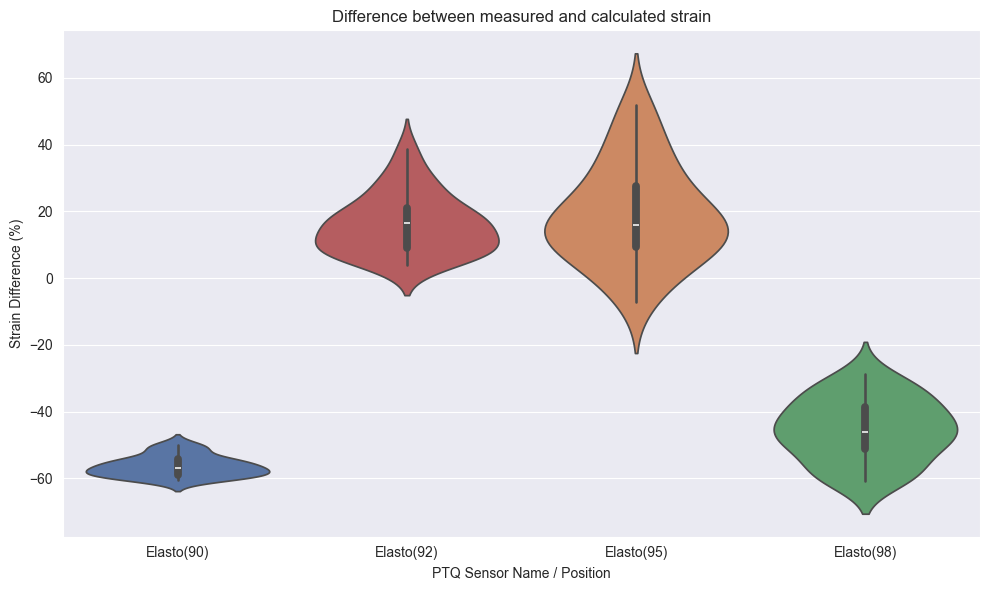

In [68]:
# Create violin plot for strain_difference grouped by sensor_name
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='sensor_name', y='strain_difference', hue='sensor_name', palette=sensor_color_dict, data=df)
plt.title('Difference between measured and calculated strain')
plt.xlabel('PTQ Sensor Name / Position')
plt.ylabel('Strain Difference (%)')
# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="diff_measured_vs_calc_strain", subdir="measured_vs_calc_strain")

In [69]:
# Latex Ausgabe der Tabelle zur Übernahme in Dokument
df_latex = df.copy()[["id", "sensor_name", "location", "height", "diameter", "rope_release", "max_strain", "calc_max_strain", "strain_difference"]]
# Spalten umbenennen
df_latex.columns = ["id", "sensor", "location", "height", "diameter", "release_force", "max_strain", "calc_max_strain", "difference"]
latex_string = df_latex.to_latex(index=False, escape=True, column_format="lllrrrrrr", float_format="{:0.2f}".format)

latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Vergleich gemessene und rechnerische Faserdehnung}}
    {latex_string}
    \\label{{tab:Feldversuch_2_Vergleich_gemessene_und_rechnerische_Faserdehnung}}
\\end{{table}}
"""
print(latex_table)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Vergleich gemessene und rechnerische Faserdehnung}
    \begin{tabular}{lllrrrrrr}
\toprule
id & sensor & location & height & diameter & release\_force & max\_strain & calc\_max\_strain & difference \\
\midrule
2 & Elasto(95) & StA & 11.60 & 0.25 & 2.72 & 254.40 & 296.98 & 16.74 \\
2 & Elasto(98) & StA & 16.85 & 0.20 & 2.72 & 207.90 & 111.93 & -46.16 \\
2 & Elasto(92) & StB & 11.60 & 0.24 & 2.72 & 282.60 & 308.86 & 9.29 \\
2 & Elasto(90) & StB & 16.55 & 0.18 & 2.72 & 429.60 & 181.50 & -57.75 \\
3 & Elasto(95) & StA & 11.60 & 0.25 & 2.76 & 262.20 & 301.23 & 14.88 \\
3 & Elasto(98) & StA & 16.85 & 0.20 & 2.76 & 193.70 & 113.53 & -41.39 \\
3 & Elasto(92) & StB & 11.60 & 0.24 & 2.76 & 291.50 & 313.28 & 7.47 \\
3 & Elasto(90) & StB & 16.55 & 0.18 & 2.76 & 427.80 & 184.10 & -56.97 \\
4 & Elasto(95) & StA & 11.60 & 0.25 & 2.74 & 250.10 & 298.77 & 19.46 \\
4 & Elasto(98) & StA & 16.85 & 0.20 & 2.74 & 171.80 & 112.61 & -34.46 \\
4 & E

In [70]:
# Data Dictionary erstellen
data_dict = {
    "Variable": ["id", "sensor", "loc", "height", "diameter", "release_force", "max_strain", "calc_max_strain", "difference"],
    "Deutsch": ["ID", "Sensor ID", "Position", "Höhe", "Durchmesser", "Vorspannung", "Gemessene Dehnung", "Berechnete Dehnung", "Relative Differenz"],
    "Datentyp": [str(dtype) for dtype in df_latex.dtypes.tolist()],
    "Einheit": ["-", "-", "-", "m", "m", "kN", "$(\mu)$m", "$(\mu)$m", "%"],
    "Beschreibung": ["ID der Messung", "ID des Sensors", "Ort am Baum", "Höhe ü. dem Boden", "Durchmesser des Stammes", "Tatsächlich realisiert Vorspannung Zugseil bei Release", "Gemessene maximale Randfaserdehnung", "Berechnete maximale Randfaserdehnung", "Relative Differenz der Dehnung"]
}

# Dataframe für das Data Dictionary erstellen
data_dict_df = pd.DataFrame(data_dict)
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Vergleich gemessene und rechnerische Faserdehnung, Daten Dokumentation}}
    {latex_string_dict}
    \\label{{tab:Feldversuch_2_Vergleich_gemessene_und_rechnerische_Faserdehnung_Daten_Dokumentation}}
\\end{{table}}
"""
print(latex_table_dict)


\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Vergleich gemessene und rechnerische Faserdehnung, Daten Dokumentation}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
id & ID & int64 & - & ID der Messung \\
sensor & Sensor ID & category & - & ID des Sensors \\
loc & Position & category & - & Ort am Baum \\
height & Höhe & Float64 & m & Höhe ü. dem Boden \\
diameter & Durchmesser & Float64 & m & Durchmesser des Stammes \\
release\_force & Vorspannung & float64 & kN & Tatsächlich realisiert Vorspannung Zugseil bei Release \\
max\_strain & Gemessene Dehnung & float64 & \$(\textbackslash mu)\$m & Berechnete maximale Randfaserdehnung \\
calc\_max\_strain & Berechnete Dehnung & float64 & \$(\textbackslash mu)\$m & Gemessene maximale Randfaserdehnung \\
difference & Relative Differenz & float64 & \% & Relative Differenz der Dehnung \\
\bottomrule
\end{tabular}

    \label{tab:Feldversuch_2_Vergleich_gemessene_und_rechnerisc

In [71]:
df[['calc_max_strain', 'max_strain', 'strain_difference']].mean()

calc_max_strain      195.798603
max_strain           248.420370
strain_difference    -16.685443
dtype: float64

### Theoretische Berechnungen der Belastung der KS

In [72]:
def calculate_force(epsilon: float, H: float, h: float, d: float, E: float) -> float:
    """
    Berechnet die Zugkraft force (in kN) basierend auf der Randfaserdehnung epsilon bzw. der Dehnung an der Elastizitätsgrenze.
    
    Parameters:
        epsilon (float): Randfaserdehnung (dimensionslos, nicht in %)
        H (float): Höhe des Angriffspunktes der Zugkraft über dem Stammfuß (m)
        h (float): Höhe des Berechnungspunktes über dem Boden (m)
        d (float): Durchmesser des Stammquerschnitts auf Höhe h (m)
        E (float): Elastizitätsmodul des Holzes (in MPa)
    
    Returns:
        float: Berechnete Zugkraft force (in kN)
    """
    y_max = d / 2  # maximaler Abstand zur neutralen Achse in m
    I = (np.pi / 64) * d**4  # Flächenträgheitsmoment in m^4
    E_Pa = E * 1e6  # Umrechnung des Elastizitätsmoduls von MPa in N/m^2
    force_N = (epsilon * E_Pa * I) / ((H - h) * y_max)  # Zugkraft in N
    force_kN = force_N / 1000  # Umrechnung in kN
    return force_kN

In [73]:
# Fixwerte
epsilon = 0.0026  # Elastizitätsgrenze Buche
E = 8500  # Elastizitätsmodul Buche in MPa
height_ks = 17.40  # m, Höhe des Angriffspunktes der KS
height_forke = 10.31  # m, Höhe des Zwiesels
stem_diameter = 0.35  # m, Durchmesser des Stammes knapp über dem Zwiesel

# Berechnung der Zugkraft
force = calculate_force(epsilon, height_ks, height_forke, stem_diameter, E)
force

13.12049034291625

In [74]:
tree_height = (26.15 + 27.2)/2
optimal_ks_height = ((tree_height - height_forke) * (2/3)) + height_forke
optimal_ks_height

21.22

In [75]:
force = calculate_force(epsilon, optimal_ks_height, height_forke, stem_diameter, E)
force

8.526514805799835

### PTQ: Analyse der Dehnungswerte nach Elastometer und Behandlungsvarianten

Plotten der Maximalwerte der Vorspannung für Dehnung und Stauchung. Für jede Messung werden erst die maximalen Werte berechnet und dann getrennt nach Elasto die Verteilung im Boxplot dargestellt.
Auffällig ist Elasto(90) mit den höchsten Dehnungswerten. Dieses Gerät ist am geringfügig dünneren Stämmling angebracht. Die Vorspannung wurde aufgrund der maximalen Messwerte von 429 µm nicht weiter erhöht.

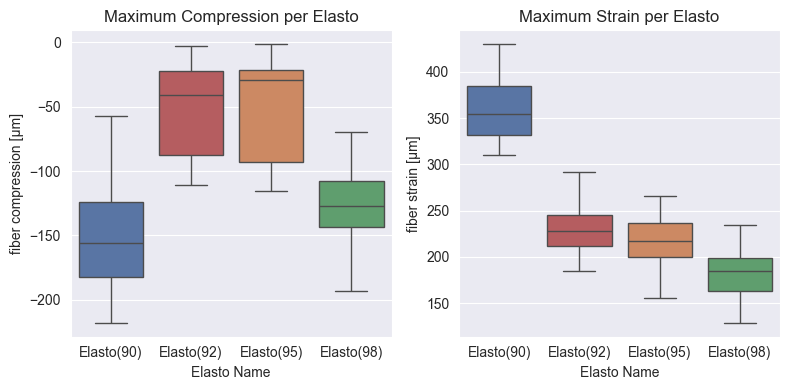

In [76]:
# Erstelle die Subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Boxplot für die minimalen Werte (maximale Compression)
sns.boxplot(data=df, x='sensor_name', y='max_compression', hue='sensor_name', palette=sensor_color_dict, ax=axs[0], legend=False)
axs[0].set_title("Maximum Compression per Elasto")
axs[0].set_xlabel("Elasto Name")
axs[0].set_ylabel("fiber compression [µm]")

# Boxplot für die maximalen Werte (maximale Strain)
sns.boxplot(data=df, x='sensor_name', y='max_strain', hue='sensor_name', palette=sensor_color_dict, ax=axs[1], legend=False)
axs[1].set_title("Maximum Strain per Elasto")
axs[1].set_xlabel("Elasto Name")
axs[1].set_ylabel("fiber strain [µm]")

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="strain_max_per_elasto", subdir="strain_max_per_elasto")

In [77]:
# Mixed-Effects Model
model = smf.mixedlm(
    "max_compression ~ C(treatment) + C(sensor_name) + rope_release",
    data=df,
    groups=df["id"]  # Gruppierung nach Beobachtungsgruppe
).fit()

# Ergebnisse
print(model.summary())


                    Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      max_compression
No. Observations:       108          Method:                  REML           
No. Groups:             27           Scale:                   516.8669       
Min. group size:        4            Log-Likelihood:          -469.9881      
Max. group size:        4            Converged:               Yes            
Mean group size:        4.0                                                  
-----------------------------------------------------------------------------
                              Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                    -148.303   17.521 -8.464 0.000 -182.643 -113.962
C(treatment)[T.gefa_dynamic]   46.255    5.443  8.497 0.000   35.586   56.924
C(treatment)[T.cobra_static]   67.115    5.443 12.331 0.000   56.447   77.783
C(sens

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [78]:
# Tukey HSD Test für die 'treatment' Gruppe
tukey_treatment = mc.pairwise_tukeyhsd(endog=df['max_compression'],
                                    groups=df['treatment'],
                                    alpha=0.05)
print(tukey_treatment)

# Tukey HSD Test für die 'ptq_sensor_name' Gruppe
tukey_sensor = mc.pairwise_tukeyhsd(endog=df['max_compression'],
                                 groups=df['sensor_name'],
                                 alpha=0.05)
print(tukey_sensor)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
cobra_static         free -66.7972    0.0 -95.6656 -37.9288   True
cobra_static gefa_dynamic  -20.925 0.2013 -49.7934   7.9434  False
        free gefa_dynamic  45.8722 0.0008  17.0038  74.7406   True
------------------------------------------------------------------
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj    lower    upper   reject
---------------------------------------------------------------
Elasto(90) Elasto(92)    102.4    0.0   76.3167 128.4833   True
Elasto(90) Elasto(95) 102.8852    0.0   76.8019 128.9684   True
Elasto(90) Elasto(98)  28.0741 0.0297    1.9908  54.1573   True
Elasto(92) Elasto(95)   0.4852    1.0  -25.5981  26.5684  False
Elasto(92) Elasto(98) -74.3259    0.0 -100.4092 -48.2427   True
Elasto(95) Elasto(9

### PTQ: Analyse der Schwingungsparameter

In diesem Abschnitt werden die Schwingungsparameter statistisch ausgewertet. Ziel ist es, den Einfluss verschiedener Behandlungsvarianten (treatment) auf die gemessenen Schwingungsparameter zu untersuchen und dabei auch den potenziellen Einfluss der Vorspannung (rope_release) und Sensorposition (sensor_name) zu berücksichtigen.


#### Überblick über die Ausgangsdaten

In [79]:
df.head(3)

,id,sensor_name,max_strain,max_compression,m_amplitude,m_amplitude_2,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,...,treatment,location,height,diameter,direction,rope_release,cable_max,calc_max_strain_relativ,calc_max_strain,strain_difference
4,2,Elasto(95),254.4,-90.4,158.65,82.05,169.477340,0.348224,0.823806,0.422702,...,free,StA,11.6,0.245099,elongation,2.7231,NaN,0.001485,296.979869,16.737370
5,2,Elasto(98),207.9,-93.8,134.65,91.35,169.982423,0.294159,0.663224,0.443529,...,free,StA,16.85,0.203718,elongation,2.7231,NaN,0.000560,111.931536,-46.160877
6,2,Elasto(92),282.6,-111.0,191.30,79.55,169.752879,0.377778,0.873595,0.432441,...,free,StB,11.6,0.241916,elongation,2.7231,NaN,0.001544,308.857683,9.291466


#### Ausgabe der Daten für Anhang (Latex)

In [139]:
# DataFrame mit den relevanten Spalten erstellen
variables_latex_1 = [
    'id',
    'sensor_name',
    'treatment',
    'release_force_target',
    'rope_release',
    'cable_max',
    'max_strain',
    'max_compression',
]

df_latex_1 = df.copy()[variables_latex_1]

# Umbenennung der Spalten für LaTeX-Notation
column_rename_map = {
    'id': 'id',
    'sensor_name': 'sensor',
    'treatment': 'treatment',
    'release_force_target': 'f_release_target',
    'rope_release': 'f_release',
    'cable_max': 'f_cable',
    'max_strain': 'max_strain',
    'max_compression': 'max_compression',
}

# Spaltennamen entsprechend der LaTeX-Notation umbenennen
df_latex_1.rename(columns=column_rename_map, inplace=True)

# DataFrame nach Kategorien in 'treatment' aufteilen
treatment_groups = df_latex_1.groupby('treatment', observed=True)

# LaTeX-Tabellen generieren
latex_tables = []
for treatment, group in treatment_groups:
    # Die 'treatment'-Spalte aus der Tabelle entfernen
    group = group.drop(columns=['treatment'])
    
    # Berechnung von mean, median und sd für numerische Spalten
    mean_row = group.mean(numeric_only=True).rename('Mean')
    median_row = group.median(numeric_only=True).rename('Median')
    sd_row = group.std(numeric_only=True).rename('SD')
    
    # Zusammenführen der Statistiken mit dem Original-DataFrame
    stats_df = pd.concat([group, mean_row.to_frame().T, median_row.to_frame().T, sd_row.to_frame().T])
    
    # LaTeX-Export des erweiterten DataFrames
    df_latex_string = stats_df.to_latex(
        index=True,
        escape=True,
        column_format="lrl|rrr|rr",
        float_format="{:0.2f}".format
    )
    
    # LaTeX-Tabellencode erstellen
    latex_table = f"""
    \\begin{{table}}[h]
        \\centering
        \\caption{{Feldversuch 2 - Ergebnisse, Kräfte und Dehnungen für {treatment}}}
        \\begin{{adjustbox}}{{max width=\\textwidth}}
        {df_latex_string}
        \\end{{adjustbox}}
        \\label{{tab:Feldversuch_2_Ergebnisse_Kräfte_Dehnung_{treatment}}}
    \\end{{table}}
    """
    
    latex_tables.append(latex_table)

# Alle Tabellen ausgeben
for table in latex_tables:
    print(table)



    \begin{table}[h]
        \centering
        \caption{Feldversuch 2 - Ergebnisse, Kräfte und Dehnungen für free}
        \begin{adjustbox}{max width=\textwidth}
        \begin{tabular}{rrl|rrr|rr}
\toprule
 & id & sensor & f\_release\_target & f\_release & f\_cable & max\_strain & max\_compression \\
\midrule
4 & 2.00 & Elasto(95) & 2.80 & 2.72 & NaN & 254.40 & -90.40 \\
5 & 2.00 & Elasto(98) & 2.80 & 2.72 & NaN & 207.90 & -93.80 \\
6 & 2.00 & Elasto(92) & 2.80 & 2.72 & NaN & 282.60 & -111.00 \\
7 & 2.00 & Elasto(90) & 2.80 & 2.72 & NaN & 429.60 & -202.20 \\
8 & 3.00 & Elasto(95) & 2.80 & 2.76 & NaN & 262.20 & -106.80 \\
9 & 3.00 & Elasto(98) & 2.80 & 2.76 & NaN & 193.70 & -139.10 \\
10 & 3.00 & Elasto(92) & 2.80 & 2.76 & NaN & 291.50 & -87.00 \\
11 & 3.00 & Elasto(90) & 2.80 & 2.76 & NaN & 427.80 & -180.00 \\
12 & 4.00 & Elasto(95) & 2.80 & 2.74 & NaN & 250.10 & -115.70 \\
13 & 4.00 & Elasto(98) & 2.80 & 2.74 & NaN & 171.80 & -160.80 \\
14 & 4.00 & Elasto(92) & 2.80 & 2.74 & NaN &

In [153]:
# Data Dictionary erstellen
data_dict = {
    "Variable": [
        "id",
        "sensor",
        "treatment",
        "f_release_target",
        "f_release",
        "f_cable",
        "max_strain",
        "max_compression"
    ],
    "Deutsch": [
        "ID",
        "Sensor ID",
        "Behandlungsvariante",
        "Ziel-Vorspannung",
        "Realisierte Vorspannung",
        "Kraftspitze KS",
        "Max.Randfaserdehnung",
        "Max.Randfaserstauchung"
    ],
    "Datentyp": [str(dtype) for dtype in df_latex_1.dtypes.tolist()],
    "Einheit": [
        "-",
        "-",
        "-",
        "kN",
        "kN",
        "kN",
        "µm",
        "µm"
    ],
    "Beschreibung": [
        "ID der Messung",
        "ID des Sensors",
        "Behandlungsvariante",
        "Geplante Vorspannung im Zugseil",
        "Tatsächlich realisiert Vorspannung Zugseil bei Release",
        "Gemessene Kraftspitze in KS",
        "Gemessene maximale Randfaserdehnung",
        "Gemessene maximale Randfaserstauchung"
    ]
}

# DataFrame für das Data Dictionary erstellen
data_dict_df = pd.DataFrame(data_dict)

# LaTeX-Export des Data Dictionary
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

# LaTeX-Tabellencode erstellen
latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Ergebnisse, Kräfte und Dehnungen, Daten-Dokumentation}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_string_dict}
    \\end{{adjustbox}}
    \\label{{tab:Feldversuch_2_Kraefte_Dehnung_Daten_Dokumentation}}
\\end{{table}}
"""

print(latex_table_dict)



\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Kräfte und Dehnungen, Daten-Dokumentation}
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
id & ID & int64 & - & ID der Messung \\
sensor & Sensor ID & category & - & ID des Sensors \\
treatment & Behandlungsvariante & category & - & Behandlungsvariante \\
f\_release\_target & Ziel-Vorspannung & float64 & kN & Geplante Vorspannung im Zugseil \\
f\_release & Realisierte Vorspannung & float64 & kN & Tatsächlich realisiert Vorspannung Zugseil bei Release \\
f\_cable & Kraftspitze KS & float64 & kN & Gemessene Kraftspitze in KS \\
max\_strain & Max.Randfaserdehnung & float64 & µm & Gemessene maximale Randfaserdehnung \\
max\_compression & Max.Randfaserstauchung & float64 & µm & Gemessene maximale Randfaserstauchung \\
\bottomrule
\end{tabular}

    \end{adjustbox}
    \label{tab:Feldversuch_2_Kraefte_Dehnung_Daten_Dokumentation}
\e

In [140]:
# DataFrame mit den relevanten Spalten erstellen
variables_latex_2 = [
    'id',
    'sensor_name',
    'treatment',
    'm_amplitude', 
    'm_amplitude_2',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped',
    'frequency_undamped',
    'y_shift',
    'pearson_r',
    'nmae',
]

df_latex_2 = df.copy()[variables_latex_2]

# Umbenennung der Spalten für LaTeX-Notation
column_rename_map = {
    'id': 'id',
    'sensor_name': 'sensor',
    'm_amplitude': r'$mA$',
    'm_amplitude_2': r'$mA_2$',
    'initial_amplitude': r'$A$',
    'damping_coeff': r'$\delta$',
    'damping_ratio': r'$D$',
    'frequency_damped': r'$f_d$',
    'frequency_undamped': r'$f_0$',
    'y_shift': r'$y$',
    'pearson_r': r'$r$',
    'nmae': r'$\text{NMAE}$',
}

# Spaltennamen entsprechend der LaTeX-Notation umbenennen
df_latex_2.rename(columns=column_rename_map, inplace=True)

# DataFrame nach Kategorien in 'treatment' aufteilen
treatment_groups = df_latex_2.groupby('treatment', observed=True)

# LaTeX-Tabellen generieren
latex_tables = []
for treatment, group in treatment_groups:
    # Die 'treatment'-Spalte aus der Tabelle entfernen
    group = group.drop(columns=['treatment'])
    
    # Berechnung von mean, median und sd für numerische Spalten
    mean_row = group.mean(numeric_only=True).rename('Mean')
    median_row = group.median(numeric_only=True).rename('Median')
    sd_row = group.std(numeric_only=True).rename('SD')
    
    # Zusammenführen der Statistiken mit dem Original-DataFrame
    stats_df = pd.concat([group, mean_row.to_frame().T, median_row.to_frame().T, sd_row.to_frame().T])
    
    # LaTeX-Export des erweiterten DataFrames
    df_latex_string = stats_df.to_latex(
        index=True, 
        escape=False,
        column_format="lrl|rrr|rr|rr|r|rr", 
        float_format="{:0.2f}".format
    )
    
    # LaTeX-Tabellencode erstellen
    latex_table = f"""
    \\begin{{table}}[h]
        \\centering
        \\caption{{Feldversuch 2 - Ergebnisse, Schwingungsparameter für {treatment}}}
        \\begin{{adjustbox}}{{max width=\\textwidth}}
        {df_latex_string}
        \\end{{adjustbox}}
        \\label{{tab:Feldversuch_2_Ergebnisse_Schwingungsparameter_{treatment}}}
    \\end{{table}}
    """
    
    latex_tables.append(latex_table)

# Alle Tabellen ausgeben
for table in latex_tables:
    print(table)



    \begin{table}[h]
        \centering
        \caption{Feldversuch 2 - Ergebnisse, Schwingungsparameter für free}
        \begin{adjustbox}{max width=\textwidth}
        \begin{tabular}{lrl|rrr|rr|rr|r|rr}
\toprule
 & id & sensor & $mA$ & $mA_2$ & $A$ & $\delta$ & $D$ & $f_d$ & $f_0$ & $y$ & $r$ & $\text{NMAE}$ \\
\midrule
4 & 2.00 & Elasto(95) & 158.65 & 82.05 & 169.48 & 0.35 & 0.82 & 0.42 & 0.43 & -19.01 & 0.91 & 0.02 \\
5 & 2.00 & Elasto(98) & 134.65 & 91.35 & 169.98 & 0.29 & 0.66 & 0.44 & 0.45 & -1.10 & 0.98 & 0.02 \\
6 & 2.00 & Elasto(92) & 191.30 & 79.55 & 169.75 & 0.38 & 0.87 & 0.43 & 0.44 & -14.23 & 0.93 & 0.02 \\
7 & 2.00 & Elasto(90) & 309.85 & 162.95 & 170.63 & 0.22 & 0.50 & 0.44 & 0.44 & -5.29 & 0.94 & 0.02 \\
8 & 3.00 & Elasto(95) & 173.95 & 94.50 & 169.86 & 0.27 & 0.62 & 0.44 & 0.44 & -3.79 & 0.94 & 0.02 \\
9 & 3.00 & Elasto(98) & 155.55 & 99.15 & 170.08 & 0.23 & 0.53 & 0.44 & 0.44 & -17.75 & 0.97 & 0.02 \\
10 & 3.00 & Elasto(92) & 188.00 & 88.40 & 170.01 & 0.26 & 0.60

In [154]:
# Data Dictionary für df_latex_2 erstellen
data_dict = {
    "Variable": [
        "id",
        "sensor",
        "treatment",
        "$mA$",
        "$mA_2$",
        "$A$",
        "$\\delta$",
        "$D$",
        "$f_d$",
        "$f_0$",
        "$y$",
        "$r$",
        "$\\text{NMAE}$"
    ],
    "Deutsch": [
        "ID",
        "Sensor ID",
        "Behandlungsvariante",
        "Amplitude (mA)",
        "Amplitude (mA2)",
        "Anfangsamplitude",
        "Dämpfungskoeffizient",
        "Dämpfungsgrad",
        "Gedämpfte Frequenz",
        "Ungedämpfte Frequenz",
        "Vertikaler Versatz",
        "Pearson-Korrelation",
        "Normalisierter MAE"
    ],
    "Datentyp": [str(dtype) for dtype in df_latex_2.dtypes.tolist()],
    "Einheit": [
        "-",
        "-",
        "-",
        "$\mu$m",
        "$\mu$m",
        "$\mu$m",
        "1/s",
        "-",
        "Hz",
        "Hz",
        "$\mu$m",
        "-",
        "-"
    ],
    "Beschreibung": [
        "ID der Messung",
        "ID des Sensors",
        "Behandlungsvariante",
        "Manuelle berechnete max. A. der Schwingung",
        "Manuelle berechnete A. zwischen 1. TP und 2. HP",
        "Initiale A. der angepassten Schwingung",
        "Koeffizient für exponentielle Dämpfung",
        "Verhältnis von Dämpfung zu Frequenz",
        "Frequenz der gedämpften Schwingung",
        "Frequenz der ungedämpften Schwingung",
        "Vertikaler Offset der Schwingung",
        "Korrelationskoeffizient der Anpassung",
        "Normalisierter mittlerer absoluter Fehler"
    ]
}

# DataFrame für das Data Dictionary erstellen
data_dict_df = pd.DataFrame(data_dict)

# LaTeX-Export des Data Dictionary
latex_string_dict = data_dict_df.to_latex(index=False, escape=True)

# LaTeX-Tabellencode erstellen
latex_table_dict = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Ergebnisse, Schwingungsparameter, Daten-Dokumentation}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_string_dict}
    \\end{{adjustbox}}
    \\label{{tab:Feldversuch_2_Schwingungsparameter_Daten_Dokumentation}}
\\end{{table}}
"""

print(latex_table_dict)



\begin{table}[h]
    \centering
    \caption{Feldversuch 2 - Ergebnisse, Schwingungsparameter, Daten-Dokumentation}
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{lllll}
\toprule
Variable & Deutsch & Datentyp & Einheit & Beschreibung \\
\midrule
id & ID & int64 & - & ID der Messung \\
sensor & Sensor ID & category & - & ID des Sensors \\
treatment & Behandlungsvariante & category & - & Behandlungsvariante \\
\$mA\$ & Amplitude (mA) & float64 & \$\textbackslash mu\$m & Manuelle berechnete max. A. der Schwingung \\
\$mA\_2\$ & Amplitude (mA2) & float64 & \$\textbackslash mu\$m & Manuelle berechnete A. zwischen 1. TP und 2. HP \\
\$A\$ & Anfangsamplitude & float64 & \$\textbackslash mu\$m & Initiale A. der angepassten Schwingung \\
\$\textbackslash delta\$ & Dämpfungskoeffizient & float64 & 1/s & Koeffizient für exponentielle Dämpfung \\
\$D\$ & Dämpfungsgrad & float64 & - & Verhältnis von Dämpfung zu Frequenz \\
\$f\_d\$ & Gedämpfte Frequenz & float64 & Hz & Frequenz de

#### Auswertung

Diese Variablen beschreiben unterschiedliche Eigenschaften des Schwingungsverhaltens, darunter Amplitudenmaße, Dehnung, Dämpfung und Frequenzen. Die letzten drei beschreiben die Qualität des der Modellanpassung

In [80]:
variables = [
    'm_amplitude', 
    'm_amplitude_2',
    'max_strain',
    'max_compression',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped',
    #'pearson_r',
    #'nrmse', 
    'nmae'
]

#### Systematischer Einfluss der Sensorposition

Ziel: Visuell erkennen, ob unterschiedliche Sensoren konsistent andere Werte liefern und ob dieser Effekt die Interpretation der treatment-Effekte erschwert.

In [81]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict,  dodge=True)
    # Stripplot: Punkte zur Veranschaulichung der Verteilung
    sns.stripplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict, dodge=True, alpha=1, jitter=True, size=5, legend=False)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss von treatment auf {var} gruppiert über sensor_name")
    plt.xlabel("Sensor Name")
    plt.ylabel(var)
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_sensor_treatment_{var}", subdir="combined/sensor")

#### Systematischer Einfluss der Behandlungsvariante

Ziel: Feststellen, ob die Variation durch unterschiedliche Behandlungen relativ zur sensorbedingten Variation unterscheidbar ist.

In [82]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name')
    sns.stripplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name', dodge=True, alpha=1, jitter=True, size=5, legend=False)
    plt.title(f"Einfluss von sensor_name auf {var} gruppiert über treatment")
    plt.xlabel("treatment")
    plt.ylabel(var)
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_treatment_sensor_{var}", subdir="combined/treatment")

#### Versuche Mixed-Linear Model
Die Daten sind hierarchisch: Mehrere Messungen (vier Sensoren) pro Beobachtungseinheit (`id`). Ein Mixed-Effects Modell könnte diese Struktur abbilden, indem zufällige Effekte für `id` und feste Effekte für `treatment` sowie `sensor_name` genutzt werden. Zusätzlich könnte `rope_release` als Kovariate eingeführt werden.

Diese Modelle wären theoretisch präziser, aber aufgrund der geringen Stichprobengröße und der komplexen Datenstruktur treten Konvergenzprobleme auf.


In [83]:
# Ergebnisse als Dictionary speichern
results_dict = {}

for var in variables:
    # Formel für MixedLM: Parameter ~ C(treatment) + C(sensor_name) + rope_release + (1|id)
    formula = f"{var} ~ C(treatment) + C(sensor_name)" #  +  rope_release
    model = smf.mixedlm(formula, data=df, groups=df["id"])
    
    # Modell fitten
    fit = model.fit(reml=True)  # REML ist Standard für gemischte Modelle
    
    # Ergebnisse ausgeben
    print(f"\n### Ergebnisse für {var} ###")
    print(fit.summary())
    
    # Überprüfen, ob das Modell konvergiert ist
    if not fit.converged:
        print("Achtung: Das Modell ist nicht konvergiert. Erwägen Sie Anpassungen (z.B. Skalierung der Daten).")
# Nach der Ausführung können Sie auf 'results_dict' zugreifen, um einzelne Modelle weiter auszuwerten.


### Ergebnisse für m_amplitude ###
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        m_amplitude
No. Observations:        108            Method:                    REML       
No. Groups:              27             Scale:                     154.5318   
Min. group size:         4              Log-Likelihood:            -431.1915  
Max. group size:         4              Converged:                 Yes        
Mean group size:         4.0                                                  
------------------------------------------------------------------------------
                              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
------------------------------------------------------------------------------
Intercept                     273.180    5.157  52.973 0.000  263.073  283.288
C(treatment)[T.gefa_dynamic]  -21.975    6.679  -3.290 0.001  -35.065   -8.885
C(treatment)[T.cobra_static]  -43.821

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für m_amplitude_2 ###
                   Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      m_amplitude_2
No. Observations:       108          Method:                  REML         
No. Groups:             27           Scale:                   192.7048     
Min. group size:        4            Log-Likelihood:          -422.6768    
Max. group size:        4            Converged:               Yes          
Mean group size:        4.0                                                
---------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                    153.766    3.272  46.995 0.000 147.353 160.179
C(treatment)[T.gefa_dynamic] -21.771    3.272  -6.654 0.000 -28.184 -15.358
C(treatment)[T.cobra_static] -49.244    3.272 -15.050 0.000 -55.657 -

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(



### Ergebnisse für initial_amplitude ###
                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    initial_amplitude
No. Observations:      108        Method:                REML             
No. Groups:            27         Scale:                 111.6384         
Min. group size:       4          Log-Likelihood:        -395.5375        
Max. group size:       4          Converged:             Yes              
Mean group size:       4.0                                                
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                    176.998    2.528 70.026 0.000 172.044 181.952
C(treatment)[T.gefa_dynamic]  -0.491    2.564 -0.191 0.848  -5.516   4.535
C(treatment)[T.cobra_static]  -5.054    2.564 -1.971 0.049 -10.080  -0.029
C(

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für damping_coeff ###
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    damping_coeff
No. Observations:      108        Method:                REML         
No. Groups:            27         Scale:                 0.0137       
Min. group size:       4          Log-Likelihood:        64.3581      
Max. group size:       4          Converged:             Yes          
Mean group size:       4.0                                            
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.081    0.028  2.948 0.003  0.027  0.136
C(treatment)[T.gefa_dynamic] 0.101    0.028  3.653 0.000  0.047  0.155
C(treatment)[T.cobra_static] 0.455    0.028 16.491 0.000  0.401  0.510
C(sensor_name)[T.Elasto(92)] 0.326    0.032 10.215 0.000

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t


### Ergebnisse für damping_ratio ###
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    damping_ratio
No. Observations:      108        Method:                REML         
No. Groups:            27         Scale:                 0.1133       
Min. group size:       4          Log-Likelihood:        -43.2756     
Max. group size:       4          Converged:             No           
Mean group size:       4.0                                            
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.154    0.079  1.939 0.052 -0.002  0.309
C(treatment)[T.gefa_dynamic] 0.207    0.079  2.613 0.009  0.052  0.363
C(treatment)[T.cobra_static] 0.987    0.079 12.444 0.000  0.832  1.143
C(sensor_name)[T.Elasto(92)] 0.866    0.092  9.460 0.000

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



### Ergebnisse für frequency_damped ###
                 Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    frequency_damped
No. Observations:    108        Method:                REML            
No. Groups:          27         Scale:                 0.0010          
Min. group size:     4          Log-Likelihood:        200.1828        
Max. group size:     4          Converged:             Yes             
Mean group size:     4.0                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.455    0.007 62.375 0.000  0.441  0.469
C(treatment)[T.gefa_dynamic]  0.013    0.007  1.845 0.065 -0.001  0.028
C(treatment)[T.cobra_static]  0.046    0.007  6.339 0.000  0.032  0.061
C(sensor_name)[T.Elasto(92)] -0.045    0

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(



### Ergebnisse für frequency_undamped ###
                 Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   frequency_undamped
No. Observations:    108       Method:               REML              
No. Groups:          27        Scale:                0.0007            
Min. group size:     4         Log-Likelihood:       217.3695          
Max. group size:     4         Converged:            No                
Mean group size:     4.0                                               
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.451    0.006 73.275 0.000  0.439  0.463
C(treatment)[T.gefa_dynamic]  0.015    0.006  2.482 0.013  0.003  0.027
C(treatment)[T.cobra_static]  0.061    0.006  9.852 0.000  0.049  0.073
C(sensor_name)[T.Elasto(92)] -0.033   

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.118404
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\statsmodels\regressio

#### Vereinfachtes Vorgehen durch Aggregation (Mittelung über Sensoren)

Um dennoch aussagekräftige Aussagen zu erhalten, werden die Messungen pro `id` über alle Sensoren gemittelt. Dadurch geht zwar die Variation aufgrund unterschiedlicher Sensoren verloren, aber es entsteht ein stabileres Datenset, in dem jede `id` einen aggregierten Wert pro Parameter hat.

Auf dieser Basis können einfache OLS-Modelle geschätzt werden, z. B. `Parameter ~ C(treatment) + rope_release`. Diese Modelle sind einfacher und sollten stabil konvergieren.

In [84]:
# Placeholder for results
results = {}

# Step 1: Compute the mean of each variable for each id
grouped_df = df.groupby("id").agg(
    {var: "mean" for var in variables}
).reset_index()

# Add additional variables (e.g., treatment and rope_release) to the aggregated data
grouped_df = grouped_df.merge(
    df[["id", "treatment", "rope_release"]].drop_duplicates(), on="id"
)

# Step 2: Fit linear models to the aggregated data
for var in variables:
    try:
        # Fit a linear model
        model = smf.ols(f"{var} ~ C(treatment) + rope_release", grouped_df).fit()

        # Store relevant results
        results[var] = {
            "p_value_treatment": model.pvalues.get("treatment[T.statisch]", None),
            "p_value_rope_release": model.pvalues.get("rope_release", None),
            "summary": model.summary()
        }
    except Exception as e:
        results[var] = {"error": str(e)}

# Display results
results

{'m_amplitude': {'p_value_treatment': None,
  'p_value_rope_release': np.float64(1.3369161812757964e-14),
  'summary': <class 'statsmodels.iolib.summary.Summary'>
  """
                              OLS Regression Results                            
  Dep. Variable:            m_amplitude   R-squared:                       0.974
  Model:                            OLS   Adj. R-squared:                  0.971
  Method:                 Least Squares   F-statistic:                     287.7
  Date:                Sat, 14 Dec 2024   Prob (F-statistic):           2.26e-18
  Time:                        13:42:05   Log-Likelihood:                -72.873
  No. Observations:                  27   AIC:                             153.7
  Df Residuals:                      23   BIC:                             158.9
  Df Model:                           3                                         
  Covariance Type:            nonrobust                                         
                     

Nicht jeder Parameter wird durch `rope_release` beeinflusst. Nur für jene Parameter, bei denen ein signifikanter Einfluss von `rope_release` festgestellt wird, soll dieser Effekt herausgerechnet werden. Auf diese Weise entstehen "bereinigte" Werte, in denen der lineare Einfluss von `rope_release` entfernt ist.

In [85]:

# Placeholder for results
# Dieses Dictionary wird nun sowohl die Modellobjekte als auch die Kennwerte speichern.
results = {}

# Liste der Variablen, für die rope_release berücksichtigt wird
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']

# Step 1: Compute the mean of each variable for each id
grouped_df = df.groupby("id").agg(
    {var: "mean" for var in variables}
).reset_index()

# Add additional variables (e.g., treatment and rope_release) to the aggregated data
grouped_df = grouped_df.merge(
    df[["id", "treatment", "rope_release"]].drop_duplicates(), on="id"
)

# Step 2: Fit linear models to the aggregated data and store model objects and p-Werte in results
for var in variables:
    # Formuliere das Modell dynamisch, abhängig davon, ob rope_release relevant ist
    if var in relevant_vars_rope_release:
        formula = f"{var} ~ C(treatment) + rope_release"
    else:
        formula = f"{var} ~ C(treatment)"

    try:
        # Fit a linear model
        model = smf.ols(formula, grouped_df).fit()

        # Store model and relevant results directly in results
        results[var] = {
            "model": model,
            "p_value_treatment": model.pvalues.get("treatment[T.statisch]", None),
            "p_value_rope_release": model.pvalues.get("rope_release", None) if var in relevant_vars_rope_release else None,
            "summary": model.summary()
        }
    except Exception as e:
        results[var] = {"error": str(e)}

# Display results
print(results)

{'m_amplitude': {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000015EC82C8350>, 'p_value_treatment': None, 'p_value_rope_release': np.float64(1.3369161812757964e-14), 'summary': <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:            m_amplitude   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     287.7
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           2.26e-18
Time:                        13:42:05   Log-Likelihood:                -72.873
No. Observations:                  27   AIC:                             153.7
Df Residuals:                      23   BIC:                             158.9
Df Model:                           3                                         
Covariance Type:        

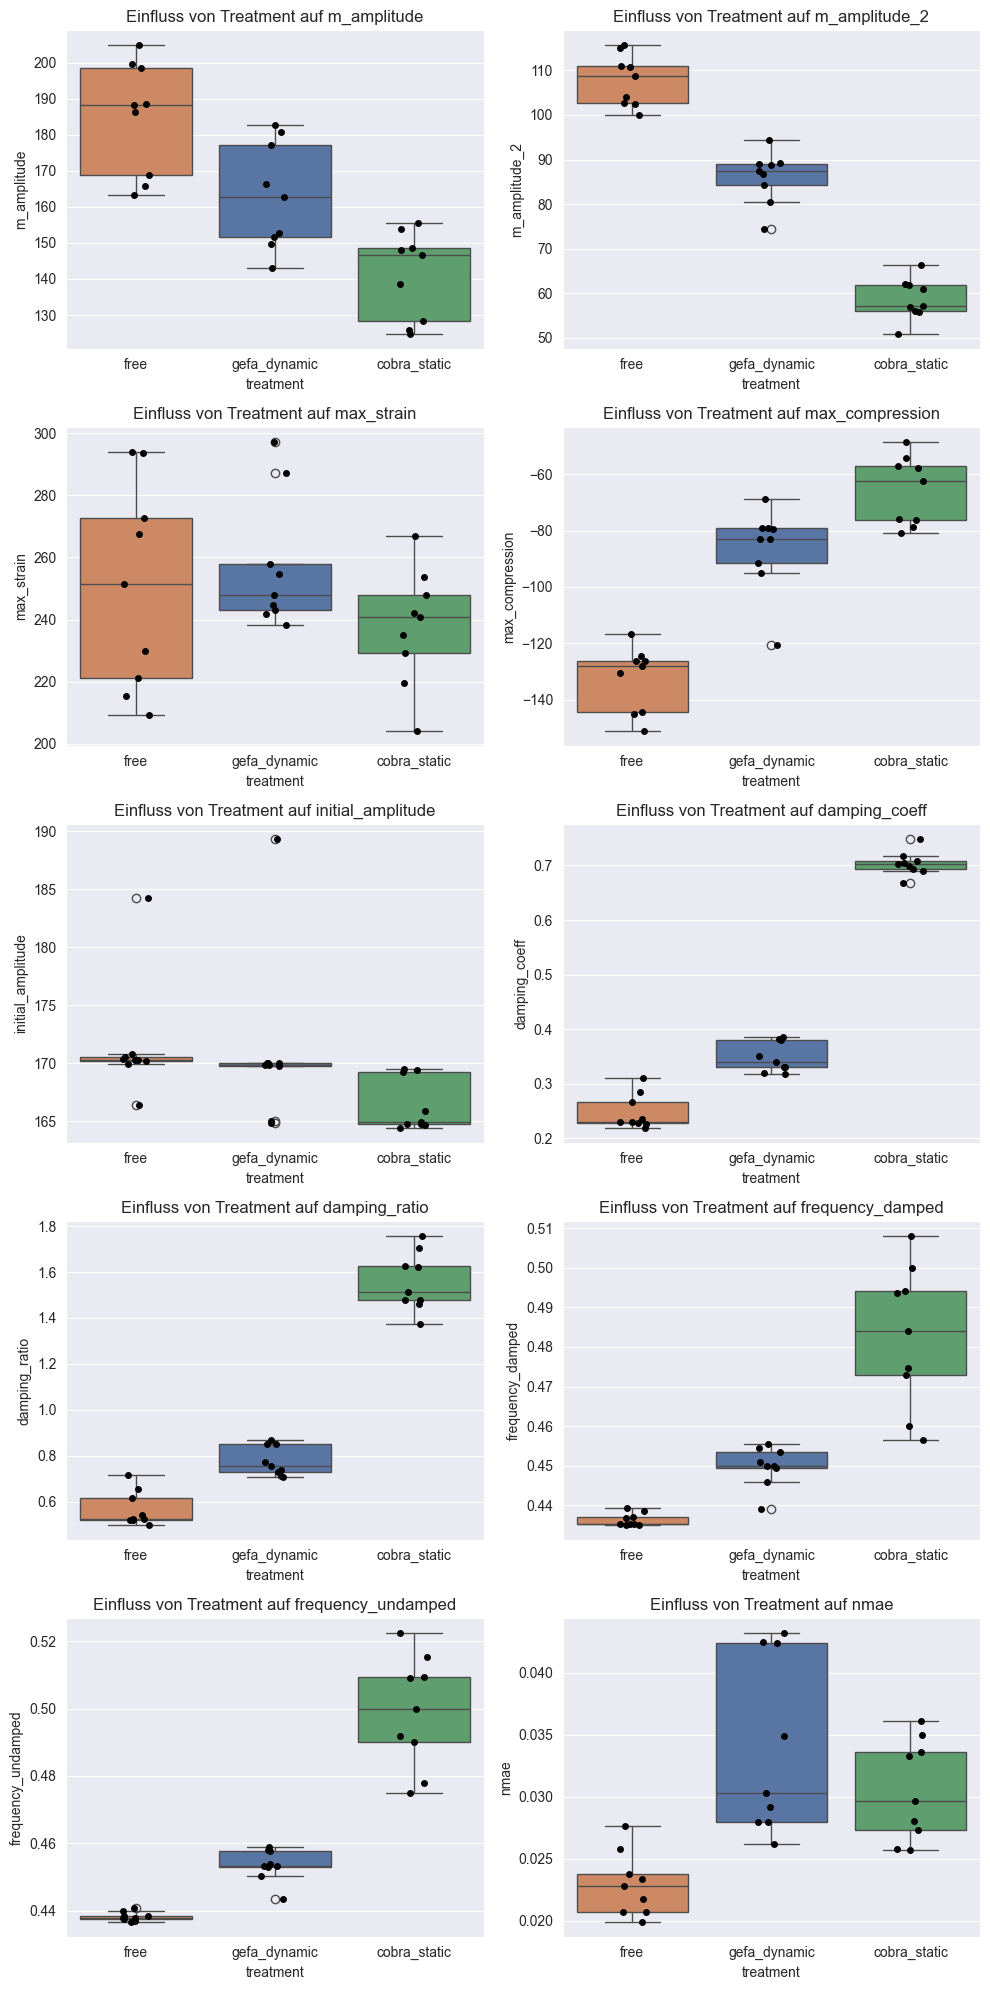

In [86]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables), 2, (len(variables) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_with_rope_release", subdir="combined")


Für die betroffenen Parameter wird der Einfluss von `rope_release` mithilfe der bereits angepassten Modelle (`Parameter ~ C(treatment) + rope_release`) entfernt. Dazu werden Vorhersagen für einen konstanten `rope_release`-Wert (den Mittelwert) berechnet und mit den tatsächlichen Werten verglichen. Die daraus resultierenden bereinigten Werte sind frei von Variation, die auf `rope_release` zurückzuführen wäre.

In [87]:
grouped_adjusted_df = grouped_df.copy()

# Bereinigung: Wir setzen rope_release auf seinen Mittelwert
rope_mean = grouped_df["rope_release"].mean()

for var in relevant_vars_rope_release:
    # Zugehöriges Modellobjekt abrufen
    model = results[var]["model"]

    # Vorhersage mit tatsächlichen rope_release-Werten
    predicted_current = model.predict(grouped_df)

    # Vorhersage, wenn rope_release = rope_mean gesetzt wird
    df_mean_rope = grouped_df.copy()
    df_mean_rope["rope_release"] = rope_mean
    predicted_mean = model.predict(df_mean_rope)

    # Angepasste Werte berechnen:
    actual = grouped_df[var].values
    adjusted = actual + (predicted_mean - predicted_current)
    grouped_adjusted_df[var] = adjusted

In [88]:
grouped_df.describe()

,id,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,nmae,rope_release
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15.000000,163.041667,84.181019,248.420370,-94.982407,169.610512,0.433525,0.967635,0.456289,0.463627,0.029100,2.371609
std,7.937254,22.751519,21.178032,25.388813,31.013660,5.539564,0.200733,0.442211,0.022321,0.027950,0.006630,0.320477
min,2.000000,124.700000,50.825000,204.125000,-151.150000,164.414848,0.218833,0.499236,0.435009,0.436606,0.019889,1.946800
25%,8.500000,148.368750,61.868750,232.437500,-125.262500,165.448089,0.275836,0.635094,0.437779,0.439278,0.024730,2.012975
50%,15.000000,162.850000,87.362500,244.750000,-83.050000,169.852283,0.339710,0.756328,0.449966,0.453330,0.027968,2.356550
75%,21.500000,181.712500,102.618750,262.400000,-75.975000,170.238775,0.692167,1.469279,0.466432,0.483997,0.033468,2.748225
max,28.000000,204.950000,115.737500,297.150000,-48.550000,189.345834,0.748603,1.757127,0.508053,0.522475,0.043212,2.780700


In [89]:
grouped_adjusted_df.describe()

,id,m_amplitude,m_amplitude_2,max_strain,max_compression,initial_amplitude,damping_coeff,damping_ratio,frequency_damped,frequency_undamped,nmae,rope_release
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,15.000000,163.041667,84.181019,248.420370,-94.982407,169.610512,0.433525,0.967635,0.456289,0.463627,0.029100,2.371609
std,7.937254,18.891324,20.934729,16.407154,30.611693,5.539564,0.200733,0.442211,0.022321,0.027950,0.006630,0.320477
min,2.000000,131.846701,51.130191,217.474556,-144.798540,164.414848,0.218833,0.499236,0.435009,0.436606,0.019889,1.946800
25%,8.500000,144.118384,61.463834,237.914892,-119.591273,165.448089,0.275836,0.635094,0.437779,0.439278,0.024730,2.012975
50%,15.000000,163.656850,87.638609,245.789741,-85.485543,169.852283,0.339710,0.756328,0.449966,0.453330,0.027968,2.356550
75%,21.500000,183.080648,105.994447,263.224917,-72.855302,170.238775,0.692167,1.469279,0.466432,0.483997,0.033468,2.748225
max,28.000000,188.972395,111.515511,273.428072,-49.047467,189.345834,0.748603,1.757127,0.508053,0.522475,0.043212,2.780700


#### Visualisierung der bereinigten Ergebnisse

Abschließend werden die bereinigten Werte grafisch dargestellt, um die Unterschiede zwischen den Behandlungen in Abwesenheit des `rope_release`-Einflusses zu verdeutlichen. Dies zeigt, wie sich die Treatments auf die Parameter auswirken würden, wenn für alle Einheiten die gleiche mittlere Vorspannung gelten würde.

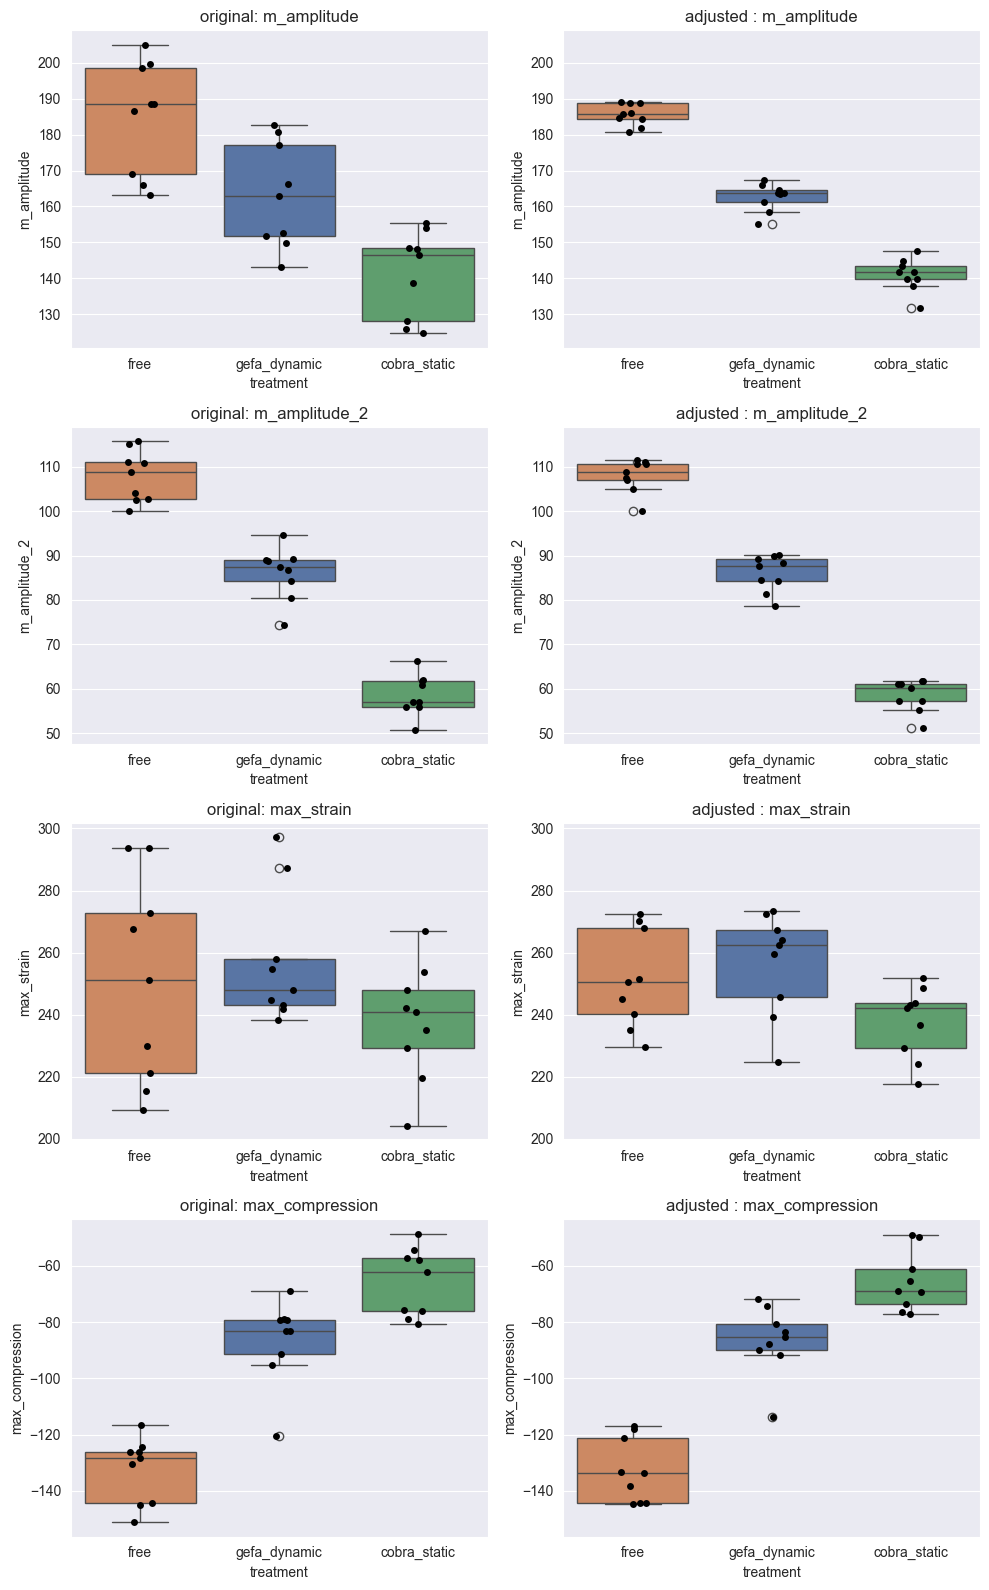

In [90]:
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']

n_vars = len(relevant_vars_rope_release)
n_cols = 2  # Links Original, rechts angepasst
n_rows = n_vars  # Eine Zeile pro Variable

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for i, var in enumerate(relevant_vars_rope_release):
    # Linke Spalte: Original (grouped_df)
    sns.boxplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,0].set_title(f"original: {var}")
    axes[i,0].set_ylabel(var)

    # Rechte Spalte: Angepasst (grouped_adjusted_df)
    sns.boxplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,1].set_title(f"adjusted : {var}")
    axes[i,1].set_ylabel(var)
    
    # Y-Limits von links holen
    y_min, y_max = axes[i,0].get_ylim()
    # Y-Limits auf rechts anwenden
    axes[i,1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_comparison", subdir="combined")


Schritt 2: Durchführung von Post-hoc-Tests

Festzustellen welche paarweisen Unterschiede zwischen den Treatments signifikant sind.

In [91]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Liste der Variablen für den Post-Hoc-Test
variables_spec = [
    'm_amplitude_2',
    'max_compression',
    'damping_coeff',
    'damping_ratio',
    'frequency_damped',
    'frequency_undamped',
    #'nmae'
]

# Wir gehen davon aus, dass grouped_adjusted_df existiert und die Spalten 'treatment' sowie die Variablen aus 'variables' enthält.

for var in variables_spec:
    # Tukey HSD Test durchführen
    # Annahme: Die Spalte 'treatment' enthält die Gruppennamen z.B. 'free', 'gefa_dynamic', 'cobra_static'
    # pairwise_tukeyhsd benötigt die abhängige Variable und die Gruppen.
    tukey_results = pairwise_tukeyhsd(endog=grouped_adjusted_df[var],
                                      groups=grouped_adjusted_df['treatment'],
                                      alpha=0.05)
    
    print(f"--- Post-Hoc Test (Tukey HSD) für Variable: {var} ---")
    print(tukey_results.summary())
    print("\n")


--- Post-Hoc Test (Tukey HSD) für Variable: m_amplitude_2 ---
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj  lower   upper  reject
---------------------------------------------------------------
cobra_static         free  49.4465   0.0 44.9605 53.9324   True
cobra_static gefa_dynamic  27.4325   0.0 22.9465 31.9184   True
        free gefa_dynamic  -22.014   0.0   -26.5 -17.528   True
---------------------------------------------------------------

--- Post-Hoc Test (Tukey HSD) für Variable: max_compression ---
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper  reject
----------------------------------------------------------------
cobra_static         free  -67.115   0.0  -80.552 -53.678   True
cobra_static gefa_dynamic -20.8603 0.002 -34.2973 -7.4233   True
        free gefa_dynamic  46.2547   0.0  32.8177 59.6917   True
-----------------------------------

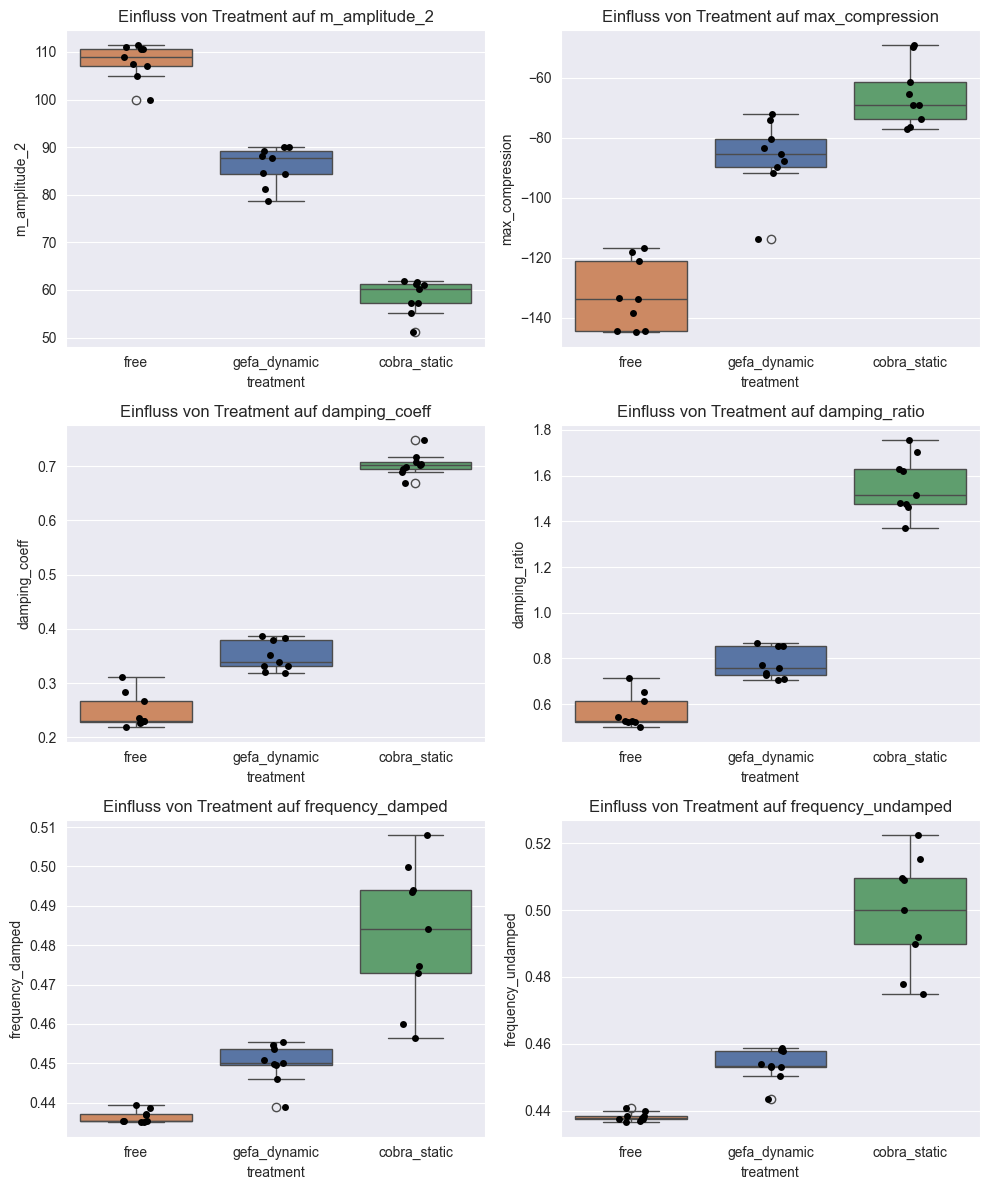

In [92]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release", subdir="combined")

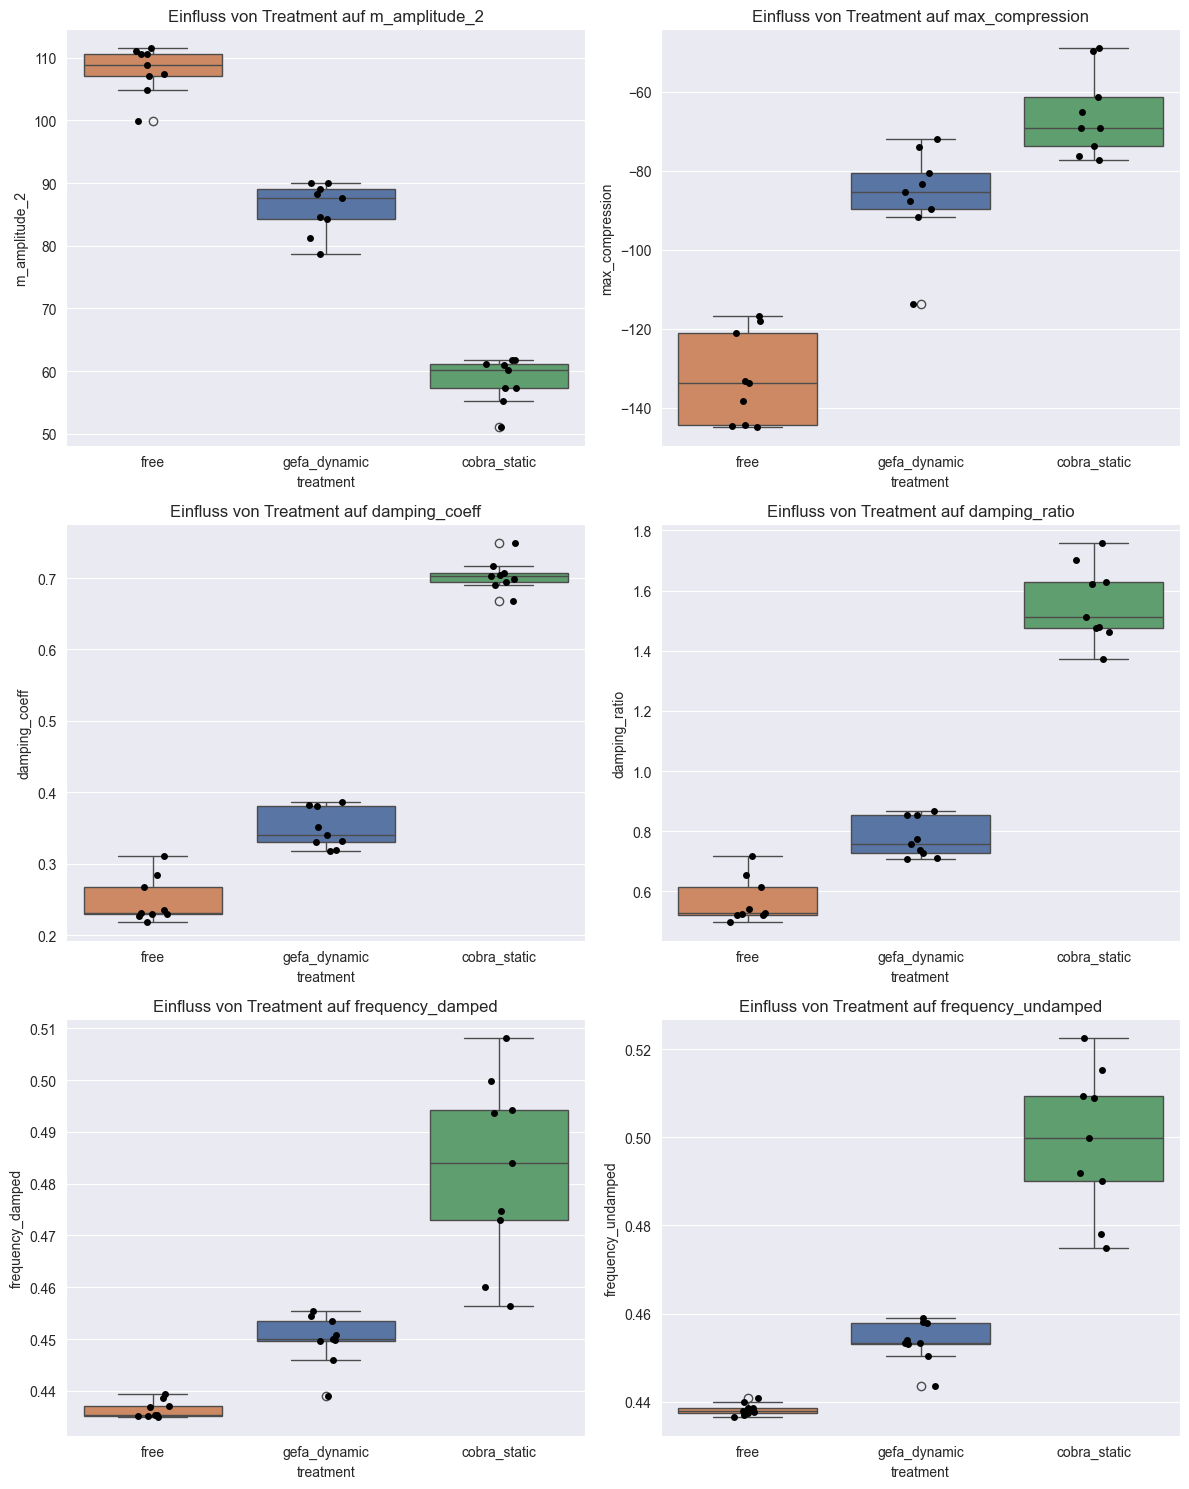

In [93]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release_spec", subdir="combined")

NameError: name 'models' is not defined

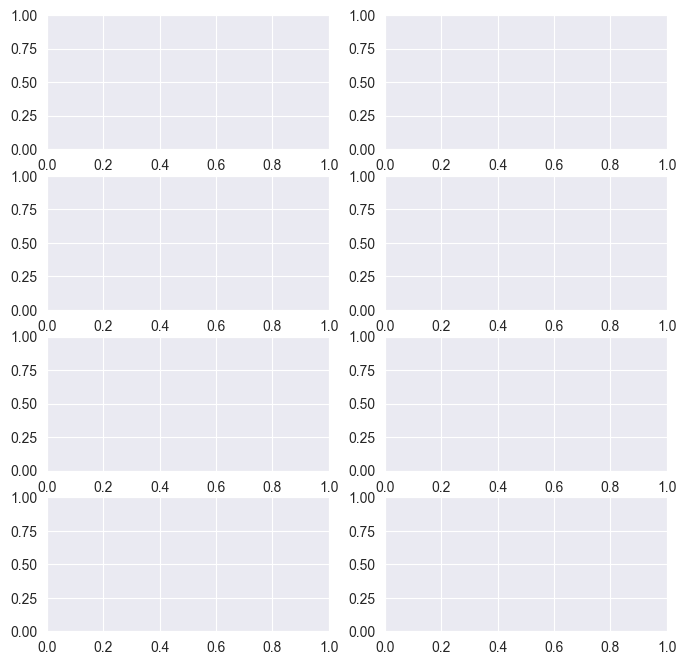

In [94]:
# Q-Q-Plots der Residuen für alle Modelle
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sm.qqplot(models[variable].resid, line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q plot for {variable} Residuals')
plt.tight_layout()
#plt.show()
PLOT_MANAGER.save_plot(fig, filename="qq_plot_residuen", subdir="combined")

In [ ]:
# Homoskedastizität prüfen (Residuals-vs-Fitted-Plot)
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    axes[i].scatter(models[variable].fittedvalues, models[variable].resid)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f'Residuals vs Fitted for {variable}')
    axes[i].set_xlabel('Fitted values')
    axes[i].set_ylabel('Residuals')
plt.tight_layout()
#plt.show()
PLOT_MANAGER.save_plot(fig, filename="residuals_vs_fitted_plot", subdir="combined")

In [ ]:
# Funktion zur Berechnung von Eta-Quadrat für alle Modelle
def eta_squared(anova_model):
    aov_table = sm.stats.anova_lm(anova_model, typ=2)
    aov_table['eta_sq'] = aov_table[:-1]['sum_sq'] / sum(aov_table['sum_sq'])
    return aov_table['eta_sq']

# Berechnung von Eta-Quadrat für alle Modelle
eta_sq_results = {}

for variable in variables:
    eta_sq_results[variable] = eta_squared(models[variable])

# Ergebnisse anzeigen
print(eta_sq_results)

#### Vorhergesagte Werte extrahieren und Boxplots für die Sensoren erstellen

In [ ]:
# Vorhergesagte Werte aus den Modellen extrahieren
for variable in variables:
    df[f'predicted_{variable}'] = models[variable].fittedvalues

# Boxplots erstellen mit den vorhergesagten Werten
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sns.boxplot(ax=axes[i], x='treatment', y=f'predicted_{variable}', data=df, palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    axes[i].set_title(f'{variable} by Treatment')
    axes[i].set_xlabel('Treatment')
    axes[i].set_ylabel(f'Predicted {variable}')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="predicted_effect_for_treatment", subdir="combined")

In [ ]:
def annotate_tukey(ax, tukey_result, significance_level=0.05):
    """
    Fügt eine Textbox mit den Tukey-Test-Ergebnissen und dem festgelegten Signifikanzniveau in den Plot ein.
    
    Parameters:
    ax (matplotlib.axes): Die Achse, auf der der Plot gezeichnet wird.
    tukey_result (TukeyHSDResults): Die Ergebnisse des Tukey HSD Tests.
    significance_level (float): Das Signifikanzniveau, standardmäßig 0.05.
    """
    # Definiere die gewünschte Reihenfolge der Vergleiche
    comparisons_order = [('free', 'gefa_dynamic'), ('free', 'cobra_static'), ('gefa_dynamic', 'cobra_static')]

    # Text für die Annotation zusammenstellen
    text_str = f"Tukey HSD Results: \n(Significance level = {significance_level:.2f})\n\n"
    
    # Durchlaufe die gewünschte Vergleichsreihenfolge
    for group1, group2 in comparisons_order:
        # Filtere die korrekte Paarung aus den Tukey-Ergebnissen
        for i in range(len(tukey_result._results_table.data[1:])):
            pair = tukey_result._results_table.data[i + 1]
            if (pair[0] == group1 and pair[1] == group2) or (pair[0] == group2 and pair[1] == group1):
                p_value = tukey_result.pvalues[i]
                significance = "*" if p_value < significance_level else "n.s."
                text_str += f"\n{group1} vs {group2}: \np = {p_value:.4f} ({significance})\n\n"
    
    # Textbox am Rand des Plots hinzufügen
    ax.annotate(text_str, xy=(1.01, 0.1), xycoords='axes fraction', va='center', ha='left')

# Einzelne Plots für jede Variable erstellen und speichern
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Boxplot für die aktuelle Variable
    sns.boxplot(ax=ax, x='treatment', y=f'predicted_{variable}', data=df, 
                palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    
    # Tukey-Test für die aktuelle Variable
    tukey_result = tukey_results[variable]
    
    # Tukey-Ergebnisse annotieren
    annotate_tukey(ax, tukey_result)
    
    ax.set_title(f'{variable} by Treatment')
    ax.set_xlabel('Treatment')
    ax.set_ylabel(f'Predicted {variable}')
    
    plt.tight_layout()
    plt.show()

    # Plot speichern
    plot_filename = f"{variable}_effect_for_treatment"
    PLOT_MANAGER.save_plot(fig, filename=plot_filename, subdir="osc_variables_box")


In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_treatment_describe = (df.drop(['id', 'ptq_sensor_name'], axis=1)
                         .groupby('treatment', observed=True)
                         .describe())

df_treatment_describe = df_treatment_describe.reset_index()
df_treatment_describe.round(2)

In [ ]:
df.dtypes

In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_sensor = (df.drop(['id', 'release_force_target', 'ls3_rope_release', 'ls3_cable_max', 'location', 'height', 'diameter', 'direction'], axis=1).
             groupby(['treatment', 'ptq_sensor_name'], observed=True).
             mean())  #.T
#df_sensor.round(4)

In [ ]:
# Gruppieren des DataFrames und Anwenden von mean für ptq_sensor_name 
df_id = ((df.drop(['ptq_sensor_name', 'location', 'height', 'diameter', 'direction'], axis=1)
          .groupby(['treatment', 'id'], observed=True)
          .mean())
         .reset_index())

df_id.round(4).head()

### Zusammenhangsanalyse für LS3 und PTQ

In [ ]:
# Auswahl der neuen Spaltennamen für die Korrelationsmatrix
columns_corr = ['ptq_m_amplitude',
                'ptq_m_amplitude_2',
                'ptq_initial_amplitude',
                'ptq_damping_coeff',
                'ptq_angular_frequency',
                'ptq_y_shift',
                'ptq_pearson_r',
                #'ptq_nrmse',
                'ptq_nmae',
                'release_force_target',
                'ls3_rope_release',
                'ls3_cable_max']
df_corr = df_id.copy()[columns_corr]

# Berechnung der Korrelationsmatrix
correlation_matrix = df_corr.corr()

# Visualisierung der Korrelationsmatrix mit Seaborn
fig1, ax = plt.subplots(figsize=(8, 8))  # Anpassen der Größe der Grafik
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, annot_kws={'size': 10})

# Titel und Schriftgrößen anpassen
#plt.title('Correlation Matrix for LS3 and PTQ', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig1, filename="correlation_matrix", subdir="combined")

In [ ]:
# ANOVA für 'ls3_rope_release'
model_rope_release = smf.ols('ls3_rope_release ~ treatment', data=df_id).fit()
anova_rope_release = sm.stats.anova_lm(model_rope_release, typ=2)

# ANOVA für 'ls3_cable_max'
model_cable_max = smf.ols('ls3_cable_max ~ treatment', data=df_id).fit()
anova_cable_max = sm.stats.anova_lm(model_cable_max, typ=2)

# Zusammenfassungen der Modelle
summary_rope_release = model_rope_release.summary()
summary_cable_max = model_cable_max.summary()
# Zusammenfassungen der Modelle
summary_rope_release_latex = model_rope_release.summary().as_latex()
summary_cable_max_latex = model_cable_max.summary().as_latex()

#print(summary_rope_release_latex)
#print(summary_cable_max_latex)

anova_rope_release, summary_rope_release, anova_cable_max, summary_cable_max

In [ ]:
# Funktion zur Erstellung des Text-Strings für die statistischen Parameter
def annotate_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    text_str = f"R = {r_value:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}\np-value = {p_value:.2e}\nStd Err = {std_err:.2f}"
    return text_str

#### Zusammenhang Ziel- und Ist-Vorspannung

In [ ]:
fig2, ax1 = plt.subplots(figsize=(8, 5))
sns.regplot(x='release_force_target', y='ls3_rope_release', data=df_id, ax=ax1, color='b', ci=95)
ax2 = ax1.twinx()
ax2.axis('off')
stats_text = annotate_stats(df_id['release_force_target'], df_id['ls3_rope_release'])
ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
#ax1.set_title('Correlation Between Target and Actual Release Forces"')
ax1.set_xlabel('Release Force Target [kN]')
ax1.set_ylabel('Release Force [kN]')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig2, filename=f"release_force_target_vs_ls3_rope_release", subdir="combined")

#### Zusammenhang Vorspannung und resultierende Lastspitzen

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ls3_cable_max'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ls3_cable_max', data=subset, ax=ax1, color=color, label=treatment, ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ls3_cable_max'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Peak Cable Force')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Peak Force in Cable [kN]')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"release_force_vs_ls3_cable_max", subdir="combined")

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude", subdir="combined")


In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude_2'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude_2', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude_2'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude 2')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude 2 [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude_2", subdir="combined")

In [ ]:
# Funktion zur Durchführung des ANOVA-Tests und Berechnung der Effektstärke (Eta Squared)
def perform_anova_and_effect_size(df: pd.DataFrame, variable: str, treatments: List[str]) -> str:
    groups = [df[df['treatment'] == treatment][variable].dropna() for treatment in treatments]
    f_stat, p_value = f_oneway(*groups)

    # Berechnung der Effektstärke (Eta Squared)
    n = sum([len(g) for g in groups])
    ss_total = sum([(x - df[variable].mean()) ** 2 for g in groups for x in g])
    eta_squared = f_stat * len(groups) / (f_stat * len(groups) + (n - len(groups)))

    # Überprüfung der Signifikanz
    significance = "*" if p_value < 0.05 else ""

    return f"{variable}: {significance}\nF-statistic = {f_stat:.2f}\np-value = {p_value:.2e}\nEta Squared = {eta_squared:.2f}"

In [ ]:
# Funktion zur Erstellung von Boxplots
def create_boxplot(df: pd.DataFrame, variable: str, group_by: str, ax: plt.Axes, color_dict: Dict[str, str], perform_stats: bool) -> None:
    valid_df = df.dropna(subset=[variable])
    sns.boxplot(x=group_by, y=variable, hue=group_by, data=valid_df, ax=ax, palette=color_dict, dodge=False)
    ax2 = ax.twinx()
    ax2.axis('off')
    if perform_stats:
        stats_text = perform_anova_and_effect_size(valid_df, variable, valid_df[group_by].unique())
        ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
    ax.set_title(f'Einfluss von {group_by} auf {variable}')
    ax.set_xlabel(group_by)
    ax.set_ylabel(variable)

# Funktion zur Erstellung kombinierter Plots
def create_combined_plot(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], num_columns: int = 3, perform_stats: bool = False) -> None:
    num_rows = len(columns) // num_columns + (len(columns) % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(columns):
        create_boxplot(df, variable, group_by, axes[idx], color_dict, perform_stats)

    plt.tight_layout()
    plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"combined_plot_{group_by}", subdir="combined")

# Funktion zur Erstellung einzelner Plots
def create_individual_plots(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], perform_stats: bool = False) -> None:
    for variable in columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        create_boxplot(df, variable, group_by, ax, color_dict, perform_stats)
        plt.tight_layout()
        #plt.show()
        PLOT_MANAGER.save_plot(fig, filename=f"{group_by}_{variable}", subdir="individual_plots")

In [ ]:
columns = ['ptq_m_amplitude',
           'ptq_m_amplitude_2',
           'ptq_initial_amplitude',
           'ptq_damping_coeff',
           'ptq_angular_frequency',
           'ptq_y_shift',
           'ptq_pearson_r',
           #'ptq_nrmse',
           #'ptq_nmae',
           #'release_force_target',
           'ls3_rope_release',
           'ls3_cable_max'
           ]

# Beispiel: Erstellen von Plots gruppiert nach 'treatment'
create_combined_plot(df, columns, 'treatment', treatment_color_dict, perform_stats=True)
create_individual_plots(df, columns, 'treatment', treatment_color_dict, perform_stats=True)

In [ ]:
# Beispiel: Erstellen von Plots gruppiert nach 'ptq_sensor_name'
columns = ['ptq_m_amplitude', 'ptq_m_amplitude_2', 'ptq_initial_amplitude', 'ptq_damping_coeff', 'ptq_angular_frequency', 'ptq_pearson_r']

create_combined_plot(df, columns, 'ptq_sensor_name', sensor_color_dict)
create_individual_plots(df, columns, 'ptq_sensor_name', sensor_color_dict)